# Installations

In [1]:
!pip install torch_geometric
!pip install torch torchvision torchaudio
!pip -q install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.0 MB/s eta 0:00:00


# Imports

In [2]:
# Tensors and neural net functions
import torch
import torch.nn.functional as F
from torch_geometric.utils import degree
# GNN Layers
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
# Auto-downloads citation graph datasets
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
# Math
import numpy as np
import pandas as pd
import re
import random
# Adejancy matrix
import networkx as nx
from sklearn.cluster import KMeans #  For clustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score # For evaluating
from __future__ import annotations

from typing import Dict, Hashable, Iterable, Optional, Tuple
from scipy.sparse import csr_matrix
from itertools import combinations
from scipy.sparse import coo_matrix, csr_matrix
from numpy.linalg import eigh # use in SpecF
from typing import List
# Plots
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# used to align cluster IDs with most common true labels
from scipy.stats import mode
import time
from collections import defaultdict, Counter
from torch_geometric.data import Data
from openpyxl import load_workbook
from openpyxl.styles import Alignment
from IPython.display import HTML, display
from pathlib import Path
import math
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from collections import deque
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.colors as mcolors

#GCN Implementation flow

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels) # Aggregates 1-hop neighbors
        self.conv2 = GCNConv(hidden_channels, out_channels) # Aggregates 2-hop neighbors

    def forward(self, x, edge_index):
        # first layer
        x = self.conv1(x, edge_index)
        # non linar activation
        x = F.relu(x)
        # second layer
        x = self.conv2(x, edge_index)
        # convert embeddings into probabilities
        return F.log_softmax(x, dim=1)

# Loading OpenAlex & setting up training

In [4]:
# 1. Configuration
domains = {
    "C41008148": "Computer Science",
    "C33923547": "Mathematics",
    "C121332964": "Physics",
    "C86803240": "Biology",
    "C185592680": "Chemistry",
    "C71924100": "Medicine",
    "C17744445": "Political Science",
    "C144024400": "Sociology",
    "C142362112": "Economics",
    "C138885662": "Psychology",
    "C95457728": "History",
    "C192562407": "Materials Science",
    "C127413603": "Engineering",
    "C127313418": "Geology",
    "C144133560": "Business"
}

email = "test@braude.ac.il" # Required for higher API limits
nodes_per_domain = 1000
all_nodes = []
node_ids = set()

print(f"Fetching ~{len(domains) * nodes_per_domain} nodes with abstracts...")

for cid, cname in domains.items():
    page = 1
    count = 0
    while count < nodes_per_domain:
        url = f"https://api.openalex.org/works?filter=concept.id:{cid},has_abstract:true&sort=cited_by_count:desc&per_page=200&page={page}&mailto={email}"
        try:
            res = requests.get(url, timeout=15).json()
            results = res.get('results', [])
            if not results: break

            for work in results:
                if work['id'] not in node_ids:
                    node_ids.add(work['id'])
                    all_nodes.append({
                        'id': work['id'],
                        'label': cname,
                        'title': work.get('display_name', 'No Title'),
                        'abstract_index': work.get('abstract_inverted_index'),
                        'refs': work.get('referenced_works', [])
                    })
                    count += 1
            page += 1
            time.sleep(0.1)
        except Exception as e:
            print(f"Error: {e}")
            break
    print(f"Completed {cname}...")

print(f"Total Nodes collected: {len(all_nodes)}")

Fetching ~15000 nodes with abstracts...
Completed Computer Science...
Completed Mathematics...
Completed Physics...
Completed Biology...
Completed Chemistry...
Completed Medicine...
Completed Political Science...
Completed Sociology...
Completed Economics...
Completed Psychology...
Completed History...
Completed Materials Science...
Completed Engineering...
Completed Geology...
Completed Business...
Total Nodes collected: 16700


In [5]:
# 1. Prepare the text data (reconstructing abstracts from the inverted index)
def reconstruct_abstract(inverted_index):
    if not inverted_index:
        return ""
    # OpenAlex abstracts are inverted; we reconstruct the string
    word_positions = []
    for word, positions in inverted_index.items():
        for pos in positions:
            word_positions.append((pos, word))
    word_positions.sort()
    return " ".join([word for pos, word in word_positions])

print("Reconstructing abstracts...")
corpus = [reconstruct_abstract(n.get('abstract_index')) for n in all_nodes]

# 2. Vectorize
print(f"Vectorizing {len(corpus)} abstracts...")
vectorizer = TfidfVectorizer(max_features=1433, stop_words='english')
x_sparse = vectorizer.fit_transform(corpus)

# 3. Convert to PyTorch Tensor [Nodes, Features]
x = torch.tensor(x_sparse.toarray(), dtype=torch.float)

print(f"✅ Success! New x shape: {x.shape}")
# Should be [16699, 1433]

Reconstructing abstracts...
Vectorizing 16700 abstracts...
✅ Success! New x shape: torch.Size([16700, 1433])


In [6]:
# 1. ID Mapping
node_map = {node['id']: i for i, node in enumerate(all_nodes)}
label_names = list(domains.values())
label_map = {name: i for i, name in enumerate(label_names)}

# 2. Build Edge Index
edges = []
for node in all_nodes:
    u = node_map[node['id']]
    for ref_id in node.get('refs', []):
        if ref_id in node_map:
            v = node_map[ref_id]
            edges.append([u, v])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2,0), dtype=torch.long)
y = torch.tensor([label_map[n['label']] for n in all_nodes], dtype=torch.long)

# 3. Create Data Object
data = Data(x=x, edge_index=edge_index, y=y)
data.titles = [n.get('title', 'No Title') for n in all_nodes]

# 4. Masks
n_nodes = data.num_nodes
indices = torch.randperm(n_nodes)
data.train_mask = torch.zeros(n_nodes, dtype=torch.bool).scatter_(0, indices[:int(n_nodes*0.6)], True)
data.val_mask = torch.zeros(n_nodes, dtype=torch.bool).scatter_(0, indices[int(n_nodes*0.6):int(n_nodes*0.8)], True)
data.test_mask = torch.zeros(n_nodes, dtype=torch.bool).scatter_(0, indices[int(n_nodes*0.8):], True)

data.validate(raise_on_error=True)
print("✅ PyG Data Object Created Successfully!")
print(data)

✅ PyG Data Object Created Successfully!
Data(x=[16700, 1433], edge_index=[2, 71255], y=[16700], titles=[16700], train_mask=[16700], val_mask=[16700], test_mask=[16700])


In [7]:
# 1. Basic Counts
print(f"Total Nodes: {data.num_nodes}")
print(f"Total Edges: {data.num_edges}")

# 2. Graph Density calculation
# Density = Actual Edges / Possible Edges
# For a directed graph: E / (V * (V - 1))
v = data.num_nodes
e = data.num_edges
density = e / (v * (v - 1)) if v > 1 else 0

print(f"Graph Density: {density:.6f}")

# 3. Average Degree (Average citations per paper within this subset)
avg_degree = e / v if v > 0 else 0
print(f"Average Degree: {avg_degree:.2f} citations per paper")

# 4. Count Isolated Nodes (Nodes with zero connections)
# This identifies papers that didn't cite any other paper in your subset
deg = degree(data.edge_index[0], num_nodes=data.num_nodes)
isolated_count = torch.sum(deg == 0).item()
print(f"Isolated Nodes: {isolated_count} ({ (isolated_count/v)*100 :.1f}%)")

Total Nodes: 16700
Total Edges: 71255
Graph Density: 0.000256
Average Degree: 4.27 citations per paper
Isolated Nodes: 5996 (35.9%)


In [8]:
# 1. Load your custom file with weights_only=False
print("Loading dataset...")
num_features = data.num_features
num_classes = int(data.y.max().item() + 1)

# 3. Setup Device
model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
# 4. Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print(f"Success! Model initialized for {num_classes} classes and {num_features} features.")

Loading dataset...
Success! Model initialized for 15 classes and 1433 features.


##Train & evaluation

In [9]:
def train():
    model.train() # sets the model in training mode
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)             # log-probs [num_nodes, num_classes]
    # Uses only training nodes. Compares predicted log-probs to true labels;
    # lower loss = better classification.
    loss = F.nll_loss(out[data.train_mask],          # NLL since model returns log_softmax
                      data.y[data.train_mask])
    loss.backward()
    optimizer.step() # updates weights using gradients
    return float(loss) # return the loss

@torch.no_grad()
def test():
    model.eval()
    # Runs forward pass, takes the class with highest log-prob for each node → predicted labels.
    out = model(data.x, data.edge_index).argmax(dim=1)
    def acc(mask):
        return (out[mask] == data.y[mask]).float().mean().item()
    return acc(data.train_mask), acc(data.val_mask), acc(data.test_mask)

# Repeats training for 200 epochs
# Every 20 epochs prints current loss and train/val/test accuracies.
# This part teaches GCN model to classify Cora nodes correctly.
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        tr, va, te = test()
        print(f"Epoch {epoch:03d} | loss {loss:.4f} | accs (train/val/test): {tr:.3f}/{va:.3f}/{te:.3f}")


/tmp/ipython-input-1339924229.py:11: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(loss) # return the loss


Epoch 020 | loss 2.0222 | accs (train/val/test): 0.396/0.322/0.321
Epoch 040 | loss 1.8123 | accs (train/val/test): 0.451/0.333/0.330
Epoch 060 | loss 1.6834 | accs (train/val/test): 0.486/0.329/0.328
Epoch 080 | loss 1.6084 | accs (train/val/test): 0.509/0.333/0.337
Epoch 100 | loss 1.5609 | accs (train/val/test): 0.520/0.335/0.334
Epoch 120 | loss 1.5295 | accs (train/val/test): 0.526/0.332/0.335
Epoch 140 | loss 1.5085 | accs (train/val/test): 0.534/0.331/0.332
Epoch 160 | loss 1.4930 | accs (train/val/test): 0.536/0.330/0.334
Epoch 180 | loss 1.4816 | accs (train/val/test): 0.541/0.335/0.332
Epoch 200 | loss 1.4735 | accs (train/val/test): 0.543/0.331/0.333


##Generating embeddings using GCN

In [10]:
def get_gcn_embeddings(model, data):
    """
    Returns:
      h1: 1-hop embeddings  [N, hidden_dim]
      h2: 2-hop embeddings  [N, out_dim]  (pre-softmax/log-softmax)
    """
    model.eval()
    h1 = F.relu(model.conv1(data.x, data.edge_index))
    h2 = model.conv2(h1, data.edge_index)  # <-- use pre-softmax as embeddings
    # Return the 2-hop structural embedding for each node
    return h2

##Clustering using K-means

In [11]:
h2 = get_gcn_embeddings(model, data)
Z = h2  # tensor [N, D]
X = Z.detach().cpu().numpy()

# Sets number of clusters = number of ground truth classes in Cora (7).
k = len(domains)
print(k)
# Run K-means
km = KMeans(n_clusters=k, n_init=10, random_state=0)
pred_clusters = km.fit_predict(X)

#  evaluate clustering quality
y_true = data.y.cpu().numpy()

15


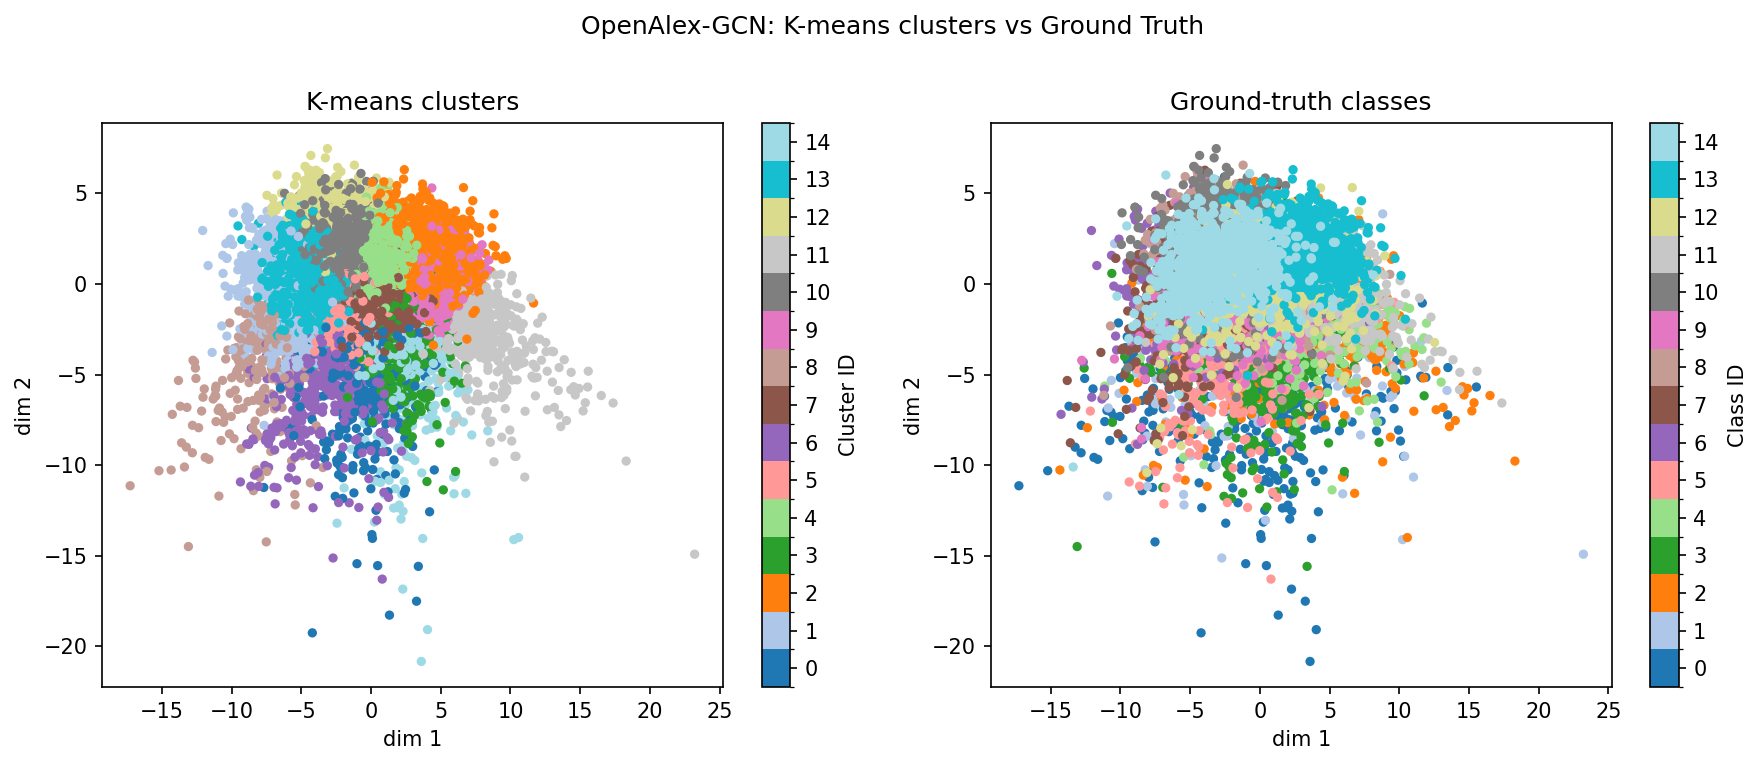

Saved plot to: /content/Results/KMeans_vs_GroundTruth.png
k (clusters) = 15 | #classes = 15


In [12]:
# --------------------------------------------------
# Reduce embeddings to 2D
# --------------------------------------------------
pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)

# --------------------------------------------------
# Discrete colormaps (so categories are clearly separated)
# --------------------------------------------------
k_clusters = int(np.unique(pred_clusters).size)
k_labels   = int(np.unique(y_true).size)

cmap_clusters = plt.get_cmap("tab20", k_clusters) if k_clusters > 10 else plt.get_cmap("tab10", k_clusters)
cmap_labels   = plt.get_cmap("tab20", k_labels)   if k_labels > 10 else plt.get_cmap("tab10", k_labels)

norm_clusters = mcolors.BoundaryNorm(np.arange(-0.5, k_clusters + 0.5, 1), cmap_clusters.N)
norm_labels   = mcolors.BoundaryNorm(np.arange(-0.5, k_labels + 0.5, 1), cmap_labels.N)

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
out_png = RESULTS_DIR / "KMeans_vs_GroundTruth.png"

# --------------------------------------------------
# One figure with two panels
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# LEFT: raw KMeans cluster IDs (0..k-1)
sc0 = axes[0].scatter(X2[:, 0], X2[:, 1], c=pred_clusters, s=12, cmap=cmap_clusters, norm=norm_clusters)
axes[0].set_title("K-means clusters")
axes[0].set_xlabel("dim 1")
axes[0].set_ylabel("dim 2")

# RIGHT: ground-truth labels (real class IDs)
sc1 = axes[1].scatter(X2[:, 0], X2[:, 1], c=y_true, s=12, cmap=cmap_labels, norm=norm_labels)
axes[1].set_title("Ground-truth classes")
axes[1].set_xlabel("dim 1")
axes[1].set_ylabel("dim 2")

# Colorbars (make IDs explicit)
cbar0 = fig.colorbar(sc0, ax=axes[0], ticks=range(k_clusters))
cbar0.set_label("Cluster ID")

cbar1 = fig.colorbar(sc1, ax=axes[1], ticks=range(k_labels))
cbar1.set_label("Class ID")

fig.suptitle("OpenAlex-GCN: K-means clusters vs Ground Truth", y=1.01)
fig.tight_layout()

fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")
print("k (clusters) =", k_clusters, "| #classes =", k_labels)

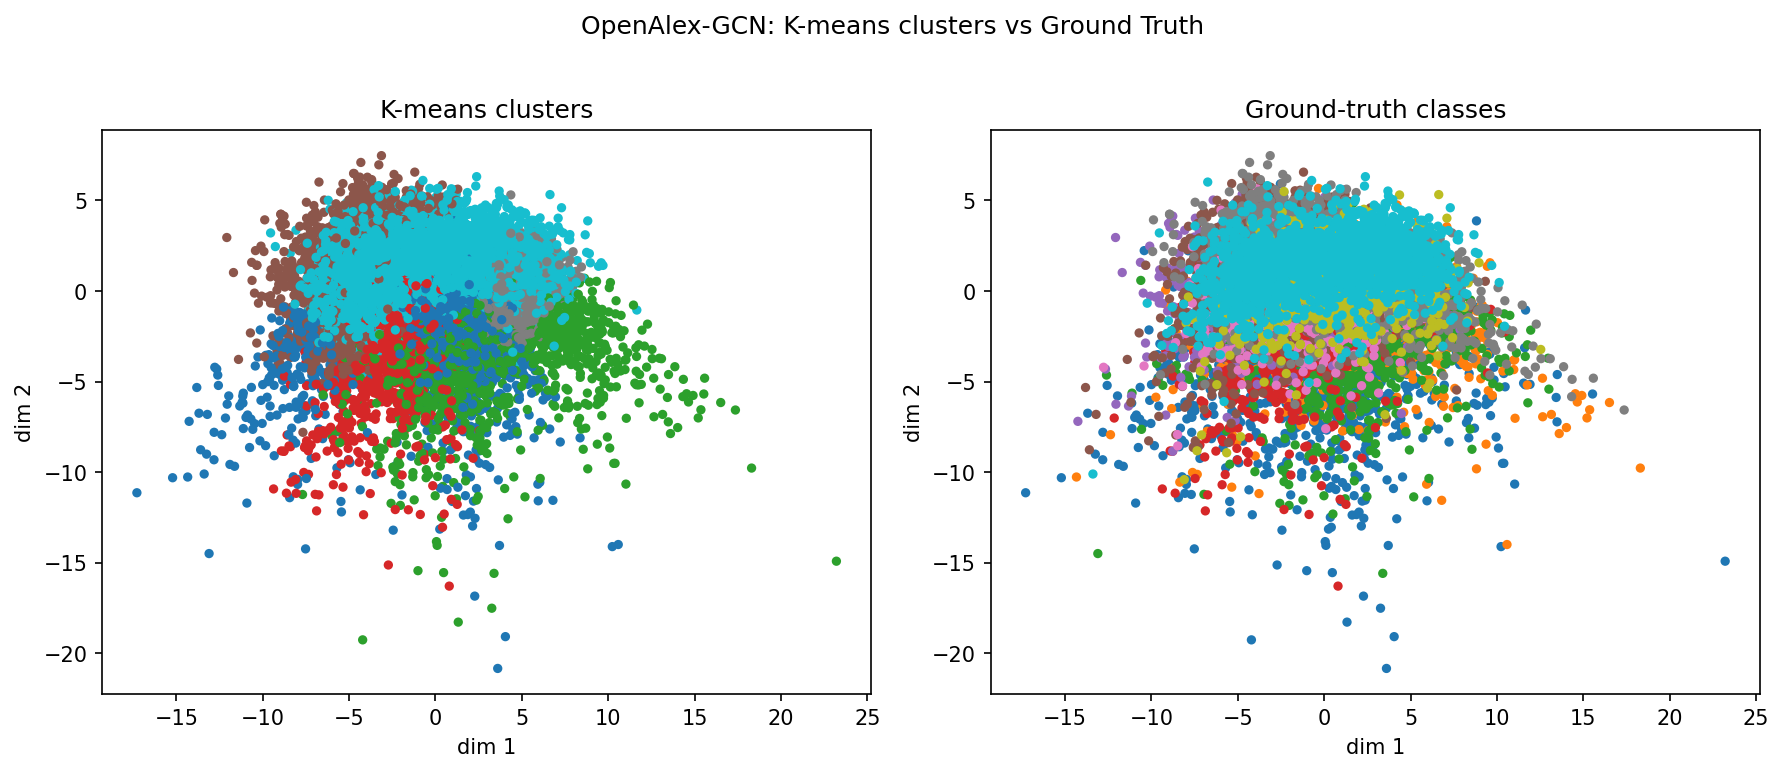

Saved plot to: /content/Results/KMeans_vs_GroundTruth_map.png


In [13]:
# --------------------------------------------------
# Align cluster IDs to dominant true labels
# --------------------------------------------------
def align_clusters_to_labels(clusters, true_labels):
    clusters_aligned = np.zeros_like(clusters)
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        most_common_label = mode(true_labels[mask], keepdims=False).mode
        clusters_aligned[mask] = most_common_label
    return clusters_aligned

clusters_aligned = align_clusters_to_labels(pred_clusters, y_true)

# --------------------------------------------------
# Reduce embeddings to 2D
# --------------------------------------------------
pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "KMeans_vs_GroundTruth_map.png"

# --------------------------------------------------
# One figure with two panels
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

axes[0].scatter(X2[:, 0], X2[:, 1], c=clusters_aligned, s=12, cmap="tab10")
axes[0].set_title("K-means clusters")
axes[0].set_xlabel("dim 1")
axes[0].set_ylabel("dim 2")

axes[1].scatter(X2[:, 0], X2[:, 1], c=y_true, s=12, cmap="tab10")
axes[1].set_title("Ground-truth classes")
axes[1].set_xlabel("dim 1")
axes[1].set_ylabel("dim 2")

fig.suptitle("OpenAlex-GCN: K-means clusters vs Ground Truth", y=1.02)
fig.tight_layout()

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")

In [14]:

def calculate_community_seeds(G, communities):
    """
    Implements Equation 11: Calculates the seed signal s_k^c for each community.
    """
    # 1. Build the Community Graph (Gc)
    Gc = nx.Graph()
    unique_comms = sorted(list(set(communities.values())))
    Gc.add_nodes_from(unique_comms)

    # Count edges between communities
    for u, v in G.edges():
        c_u = communities[u]
        c_v = communities[v]
        if c_u != c_v:
            if Gc.has_edge(c_u, c_v):
                Gc[c_u][c_v]['weight'] += 1
            else:
                Gc.add_edge(c_u, c_v, weight=1)

    # 2. Calculate Seeds (Equation 11)
    community_signals = {}
    # Sort communities by the sum of their inter-community edge weights
    sorted_comms = sorted(unique_comms, key=lambda c: sum(d['weight'] for _, _, d in Gc.edges(c, data=True)))

    for i, c in enumerate(sorted_comms):
        # sum of weights of adjacent nodes in Gc
        w_sum = sum(d['weight'] for _, _, d in Gc.edges(c, data=True))
        # Equation 11: s_i^c = sum(w_ij^c) * (i + 1)
        community_signals[c] = float(w_sum * (i + 1))

    return community_signals

## Build expanded Adjacency Matrix
The purpose is:
Constructs the expanded adjacency matrix W used in SpecF, encoding both: actual edges, and same-community non-edges

In [15]:


def build_expanded_adjacency(
    G: nx.Graph,
    communities: Dict[Hashable, int],
    *,
    w_edge_same: int = 5,
    w_edge_diff: int = 3,
    w_nonedge_same: int = 1,
    return_node_order: bool = False,
) -> Tuple[csr_matrix, list] | csr_matrix:
    """
    Build the expanded adjacency matrix W (Eq. (10) in the paper).

    Parameters
    ----------
    G : nx.Graph
        Undirected graph.
    communities : dict
        Mapping node -> community id (your K-means clusters).
    w_edge_same : int
        Weight if i-j are neighbors and in the same community (default 5).
    w_edge_diff : int
        Weight if i-j are neighbors in different communities (default 3).
    w_nonedge_same : int
        Weight if i-j are NOT neighbors and in the same community (default 1).
    return_node_order : bool
        If True, also returns the node order used for indexing rows/cols.

    Returns
    -------
    W : scipy.sparse.csr_matrix, shape (N, N)
        Expanded adjacency matrix.
    node_order : list (optional)
        The node order corresponding to rows/cols of W (only if return_node_order=True).
    """
    # fix node order (rows/cols)
    nodes = list(G.nodes())
    N = len(nodes)
    idx = {u: i for i, u in enumerate(nodes)}

    # neighbor sets
    nbrs = {u: set(G.neighbors(u)) for u in nodes}

    rows, cols, data = [], [], []

    # 1) Add all existing edges with weights 5 or 3
    for u, v in G.edges():
        i, j = idx[u], idx[v]
        same = (communities.get(u) == communities.get(v))
        w = w_edge_same if same else w_edge_diff
        rows.extend([i, j])
        cols.extend([j, i])
        data.extend([w, w])

    # 2) Add same-community non-edges (weight 1)
    # Group nodes by community
    comm2nodes: Dict[int, list] = {}
    for u, c in communities.items():
        comm2nodes.setdefault(c, []).append(u)

    for c, c_nodes in comm2nodes.items():
        # iterate unordered pairs inside the community
        for u, v in combinations(c_nodes, 2):
            # skip if (u,v) already an edge
            if v in nbrs[u]:
                continue
            i, j = idx[u], idx[v]
            rows.extend([i, j])
            cols.extend([j, i])
            data.extend([w_nonedge_same, w_nonedge_same])

    # Build sparse; zero diagonal by default
    W = coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()

    return (W, nodes) if return_node_order else W


## Generating Normal Signals

Its job:

Seed a signal inside each community:

- For each community c, find nodes in that community.

- Choose a seed node with maximum degree (or random among them).

- Set its signal s_i^c to the corresponding community-level value community_signal[c].

- Everything else initially 0.

Propagate that signal outward:

- Uses a kind of queue-based propagation:

  - Maintains a set of marked/unmarked nodes.

  - Repeatedly selects a node, pushes its signal to neighbors, and averages.

- The conceptual effect: values diffuse across the graph so that nodes connected within the same community tend to have similar values.

Final smoothing with weights:

- If W_expanded and node_order are provided (fast path):

  - Build a vector sx_vec of signals in the order of node_order.

  - Compute row_sums = W_expanded.sum(axis=1) (degree in expanded graph).

  - Compute numer = W_expanded.dot(sx_vec) (weighted sum of neighbors’ signals).

  - Set s_vec = numer / row_sums where degree > 0.

  - Convert back to a dict {node: s_i}.

- This is a weighted average using expanded adjacency, so the signal is smooth with respect to both edges and community structure.

In [16]:
# BUILD NETWORKX GRAPH G FROM PyG edge_index
edge_index = data.edge_index.cpu().numpy()
G = nx.Graph()
G.add_edges_from(zip(edge_index[0], edge_index[1]))
G.add_nodes_from(range(data.num_nodes))   # ensure isolated nodes included

def normal_signal_generator(
    G: nx.Graph,
    communities: Dict[Hashable, int],               # node -> community id
    community_signal: Dict[int, float],             # community id -> seed s_k^c
    *,
    # legacy options
    use_expanded_weights: bool = False,             # if no W_expanded is given, use 5/3 scheme
    weight_attr: str = "weight",                    # edge attr for legacy averaging
    rng: Optional[random.Random] = None,
    # NEW fast path
    W_expanded: "csr_matrix" = None,                # SciPy CSR matrix (optional)
    node_order: Optional[list] = None               # nodes ordered as W_expanded rows/cols
) -> Dict[Hashable, float]:
    """
    Algorithm 4: Normal Signal Generator (paper).
    - Seeds each community at its highest-degree node with s_k^c.
    - Propagates signals along edges with community-aware transfer t.
    - Final signal is a weighted average of propagated signals.

    Fast path:
      If W_expanded (CSR) and node_order are provided, the final averaging uses:
         s = D^{-1} W_expanded @ s_x
      where D[i] = sum_j W_expanded[i, j].
    Otherwise, falls back to the legacy (loop-based) averaging.

    Returns
    -------
    s : dict {node: s_i}  Final node signals.
    """
    if rng is None:
        rng = random.Random()

    # 1. Initialization
    # S_x will hold the intermediate propagated values
    S_x: Dict[Hashable, float] = {n: 0.0 for n in G.nodes()}
    marked = {n: True for n in G.nodes()}
    degrees = dict(G.degree())

    # Queue for BFS-like propagation
    F = deque()

    # 2. Seed Selection (Heads of Communities)
    # Identify unique communities present in the graph
    present_communities = set(communities.values())

    # Pre-group nodes by community for efficiency
    nodes_by_comm = {c: [] for c in present_communities}
    for n, c in communities.items():
        if n in G:  # Ensure node is in graph
            nodes_by_comm[c].append(n)

    # Assign seed values to the highest degree node in each community
    for c in present_communities:
        nodes = nodes_by_comm[c]
        if not nodes:
            continue

        # Sort by degree (descending) then ID to break ties deterministically
        # Note: we use str(n) for ID sorting to handle mixed types if necessary
        head = max(nodes, key=lambda n: (degrees[n], str(n)))

        # Assign the seed signal for this community
        if c in community_signal:
            S_x[head] = community_signal[c]
            marked[head] = False
            F.append(head)

    # 3. Propagation Process (The core of Algorithm 4)
    while F:
        v_i = F.popleft()
        val_i = S_x[v_i]

        # Get neighbors (sorted for determinism if needed, but omitted for speed)
        neighbors = list(G.neighbors(v_i))

        for v_j in neighbors:
            # Calculate transfer rate 't'
            # If same community: t depends on degrees
            if communities[v_i] == communities[v_j]:
                d_i = degrees[v_i]
                d_j = degrees[v_j]
                denom = d_i + d_j
                mt = (d_i / denom) if denom > 0 else 0
                t = max(0.25, mt)
            else:
                # Different community: fixed low transfer rate
                t = 0.1

            # Update neighbor value: s_j <- s_j + (s_i * t)
            S_x[v_j] += val_i * t

            # Decay source value: s_i <- s_i * 0.95
            S_x[v_i] *= 0.95
            # Update local var to reflect decay for next neighbor (optional interpretation,
            # but usually decay happens once per propagation step.
            # Sticking to the paper's "After the propagation process... reduced by 5%" implies
            # it might happen after interacting with all neighbors, but iterative implementations
            # often decay per interaction. Here we decay the source *in the dict*.)

            # Add neighbor to queue if it hasn't been a source yet
            if marked[v_j]:
                marked[v_j] = False
                F.append(v_j)

        # Update the decayed value in the main dict for v_i
        S_x[v_i] = val_i * 0.95

    # 4. Final Normalization
    # We apply the weighted average smoothing.

    # PATH A: Fast path with Precomputed W_expanded
    if W_expanded is not None:
        if node_order is None:
            raise ValueError("node_order must be provided if W_expanded is used.")

        # Create a vector aligned with node_order
        n_nodes = len(node_order)
        s_vector = np.zeros(n_nodes)

        # Map S_x dict to vector
        # Create a fast lookup for node indices
        node_to_idx = {n: i for i, n in enumerate(node_order)}

        for n, val in S_x.items():
            if n in node_to_idx:
                s_vector[node_to_idx[n]] = val

        # Perform matrix multiplication: S_smooth = D^-1 * W * S
        # Compute sum of weights (degrees) for normalization
        # W_expanded is CSR, sum(axis=1) returns a matrix (n,1), flatten to array
        weighted_sums = W_expanded.dot(s_vector)
        degree_sums = np.array(W_expanded.sum(axis=1)).flatten()

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            s_smooth_vec = weighted_sums / degree_sums
            s_smooth_vec = np.nan_to_num(s_smooth_vec)

        # Map back to dict
        return {n: float(s_smooth_vec[i]) for i, n in enumerate(node_order)}

    # PATH B: Legacy Manual Calculation
    else:
        S_final = {}
        for i in G.nodes():
            neighbors = list(G.neighbors(i))

            # If isolated, keep original value
            if not neighbors:
                S_final[i] = S_x[i]
                continue

            numerator = 0.0
            denominator = 0.0

            # Define weights based on strategy
            if use_expanded_weights:
                # "Expanded" strategy: 5 for same comm, 3 for diff comm
                # We include self-loop with weight 5 (high affinity to self/comm)

                # Self
                w_self = 5.0
                numerator += w_self * S_x[i]
                denominator += w_self

                c_i = communities[i]

                for j in neighbors:
                    if c_i == communities[j]:
                        w = 5.0
                    else:
                        w = 3.0
                    numerator += w * S_x[j]
                    denominator += w
            else:
                # Standard strategy: use edge weight attribute or 1.0
                # Self (standard usually doesn't emphasize self as heavily, using 1.0 or 0)
                # Here we strictly average neighbors + self? Or just neighbors?
                # Standard smoothing usually involves self. Let's assume weight 1 for self.
                numerator += S_x[i]
                denominator += 1.0

                for j in neighbors:
                    w = G[i][j].get(weight_attr, 1.0)
                    numerator += w * S_x[j]
                    denominator += w

            S_final[i] = numerator / denominator if denominator > 0 else 0.0

        return S_final

# 1. Map communities
clusters_dict = {i: int(c) for i, c in enumerate(pred_clusters)}

# 2. CALCULATE SEEDS (The missing step)
# This uses the inter-community edge counts to set the base intensity
Sc = calculate_community_seeds(G, clusters_dict)

# 3. Build W_expanded
W_expanded, node_order = build_expanded_adjacency(G, clusters_dict, return_node_order=True)

# 4. Propagation (Algorithm 4)
# Now Sc contains the paper-derived s_k^c values
S_normal = normal_signal_generator(
    G,
    communities=clusters_dict,
    community_signal=Sc,
    W_expanded=W_expanded,
    node_order=node_order
)

B = S_normal

# Visualization of the signal 𝐵 on the nodes embeddings

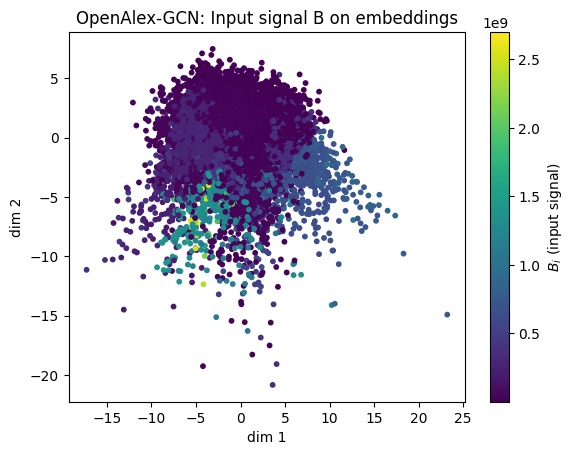

In [17]:
# convert dict -> array, assuming node ids are 0..N-1
vals_B = np.array([B[i] for i in range(len(B))])

plt.figure()
plt.scatter(X2[:,0], X2[:,1], c=vals_B, s=10, cmap="viridis")
plt.colorbar(label=r"$B_i$ (input signal)")
plt.title("OpenAlex-GCN: Input signal B on embeddings")
plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.show()


#**SpecF**

In [18]:
def specf_anomaly_detection(
    W_expanded: csr_matrix,
    B: Dict[Hashable, float],          # anomalous signal: node -> b_i
    communities: Dict[Hashable, int],  # node -> community id (from K-means)
    node_order: list,                  # order used when building W_expanded
    k: int | None = None               # how many low-frequency modes to keep
):
    """
    SpecF implementation (sparse / scalable version):

    - Build sparse Laplacian L = D - W_expanded.
    - Compute only the k smallest eigenpairs of L (low frequencies).
    - Graph Fourier transform of B using those eigenvectors.
    - Reconstruct a smoothed signal b' from low-frequency modes only.
    - Y = |B - B'| = anomaly score per node.
    - Per-community thresholding to get the anomaly set.
    """

    # 1. Build signal vector in the same order as W_expanded
    N = W_expanded.shape[0]
    assert len(node_order) == N, "node_order must match W_expanded shape"
    b_vec = np.array([B[n] for n in node_order], dtype=float)

    # 2. Build sparse Laplacian L = D - W_expanded
    deg = np.array(W_expanded.sum(axis=1)).ravel()
    D = diags(deg)                       # sparse degree matrix
    L = D - W_expanded                  # sparse Laplacian

    # 3. Decide how many eigenvectors to compute
    if k is None:
        k = len(set(communities.values()))   # use #communities if not given

    # Safety: k must be < N and at least 1
    k = max(1, min(k, N - 2))

    # 4. Compute the k smallest eigenpairs of L (low frequencies)
    # eigsh works with sparse symmetric matrices
    eigvals, U_low = eigsh(L, k=k, which="SM")   # shape U_low: (N, k)

    # (Optional) sort them by eigenvalue ascending
    order = np.argsort(eigvals)
    eigvals = eigvals[order]
    U_low = U_low[:, order]

    # 5. Graph Fourier transform of B on the low-frequency basis
    #    b_hat_low[l] = u_l^T b
    b_hat_low = U_low.T @ b_vec           # shape (k,)

    # 6. Ideal low-pass filter:
    #    since we only have the k smallest eigenvectors,
    #    using all of them is equivalent to keeping frequencies λ_0..λ_{k-1}
    #    and discarding all higher ones.
    #    -> no extra masking needed: they are already low-pass.

    # 7. Inverse transform (reconstruction from low-frequency modes)
    #    b'(i) = sum_{l=0}^{k-1} b_hat_low[l] * u_l(i)
    b_prime = U_low @ b_hat_low           # shape (N,)

    # 8. Anomaly scores Y = |B - B'|
    y_vec = np.abs(b_vec - b_prime)
    Y_scores = {n: y_vec[i] for i, n in enumerate(node_order)}  # node -> y_i

    # 9. Per-community thresholding
    anomalies = []
    comm_to_nodes: Dict[int, list] = {}
    for n in node_order:
        c = int(communities[n])
        comm_to_nodes.setdefault(c, []).append(n)

    for c, nodes_c in comm_to_nodes.items():
        vals = np.array([Y_scores[n] for n in nodes_c], dtype=float)
        if len(vals) == 0:
            continue

        mu = vals.mean()
        sigma = vals.std()

        # Threshold: mean + 2 * std within each community
        #   y_i > μ_c + 2 σ_c  ⇒ anomalous
        threshold = mu + 2.0 * sigma

        for n, y in zip(nodes_c, vals):
            if y > threshold:
                anomalies.append(n)

    return Y_scores, anomalies


In [19]:
# Calling SpecF Algorithm
k_communities = len(set(clusters_dict.values()))
print("Number of communities (k):", k_communities)

Y_scores, specf_anomalies = specf_anomaly_detection(
    W_expanded=W_expanded,
    B=B,
    communities=clusters_dict,
    node_order=node_order,
    k=k_communities
)

print(f"SpecF flagged {len(specf_anomalies)} anomalous nodes.")
print("First 10:", specf_anomalies[:10])



Number of communities (k): 15
SpecF flagged 436 anomalous nodes.
First 10: [np.int64(4883), np.int64(145), np.int64(2942), np.int64(2666), np.int64(1009), np.int64(2193), np.int64(2192), np.int64(2244), np.int64(1000), np.int64(1008)]


# Results

# Nodes Colored by SpecF Score 𝑌𝑖 with anomalous in red circle

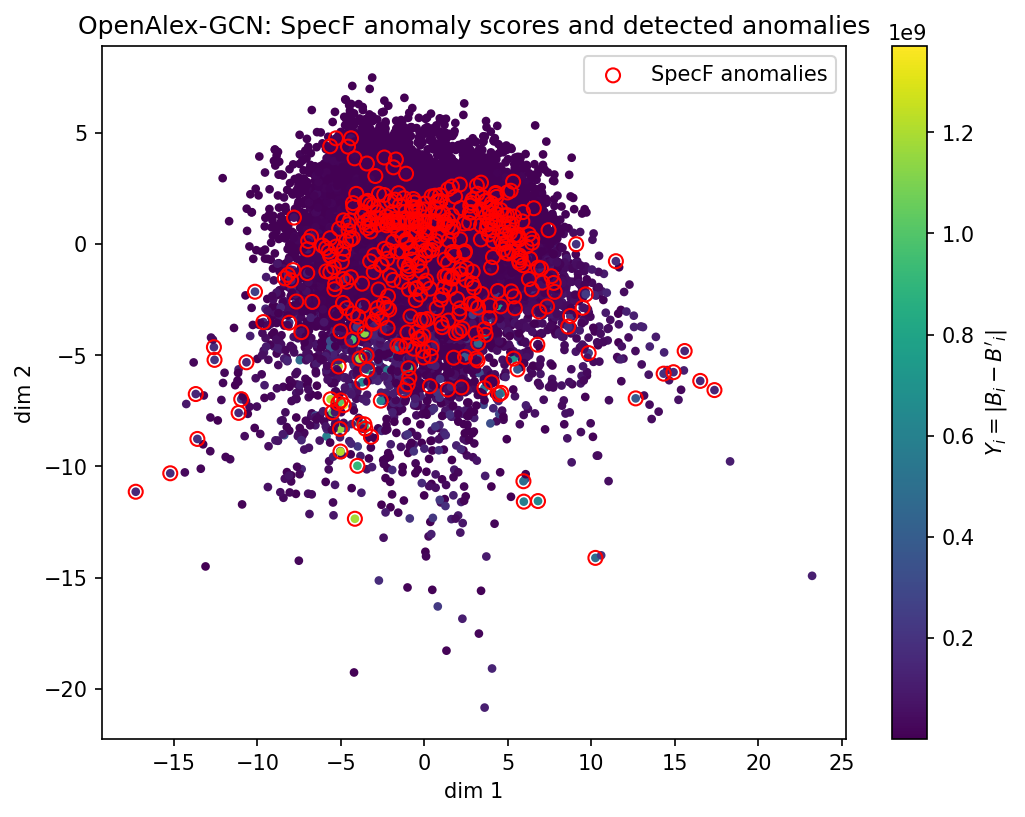

Saved plot to: /content/Results/SpecF_scores_with_anomalies.png


In [20]:
# SpecF score vector in node-id order 0..N-1
N = len(node_order)  # should equal data.num_nodes
vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)

# anomaly mask for highlighting circles
mask = np.zeros(N, dtype=bool)
mask[specf_anomalies] = True

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_scores_with_anomalies.png"


fig = plt.figure(figsize=(8, 6), dpi=150)
sc = plt.scatter(X2[:, 0], X2[:, 1], c=vals_Y, s=10, cmap="viridis")
plt.colorbar(sc, label=r"$Y_i = |B_i - B'_i|$")

plt.scatter(
    X2[mask, 0], X2[mask, 1],
    s=45, edgecolors="red", facecolors="none", linewidths=1.0,
    label="SpecF anomalies"
)

plt.legend(loc="best")
plt.title("OpenAlex-GCN: SpecF anomaly scores and detected anomalies")
plt.xlabel("dim 1")
plt.ylabel("dim 2")

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")

# Nodes Colored by B𝑖 Score with anomalous in red circle

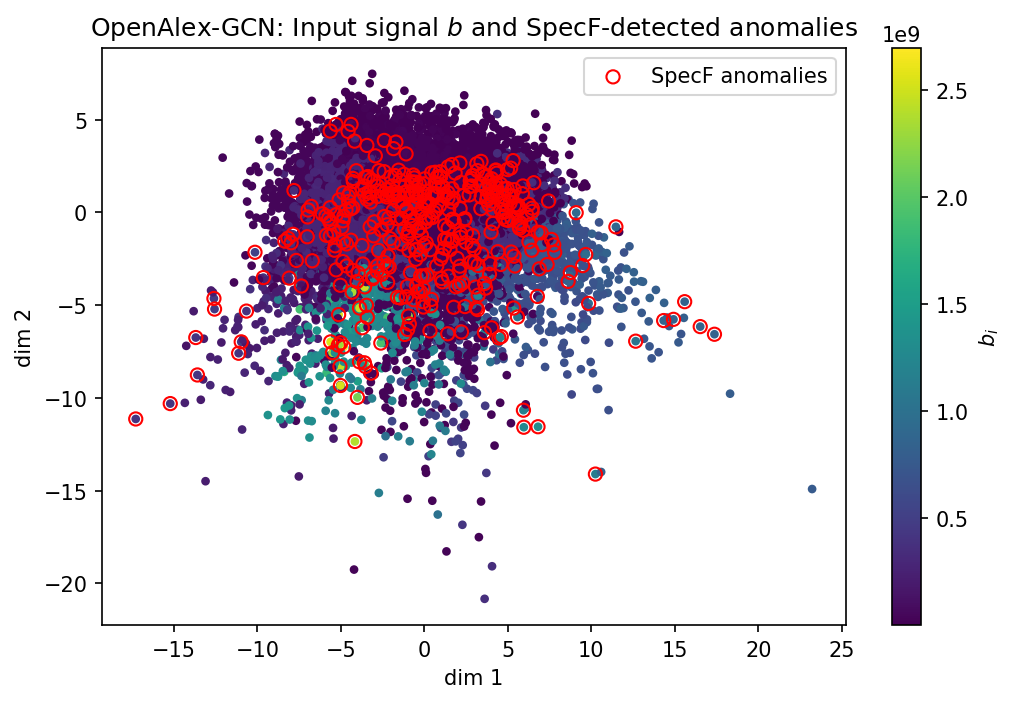

Saved plot to: /content/Results/InputSignal_b_with_anomalies.png


In [21]:
# --------------------------------------------------
# Input signal b in node-id order 0..N-1
# --------------------------------------------------
N = len(node_order)  # should equal data.num_nodes
vals_b = np.array([B[i] for i in range(N)], dtype=float)

# anomaly mask for highlighting circles
mask = np.zeros(N, dtype=bool)
mask[specf_anomalies] = True

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "InputSignal_b_with_anomalies.png"

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig = plt.figure(figsize=(8, 5), dpi=150)

sc = plt.scatter(
    X2[:, 0], X2[:, 1],
    c=vals_b, s=10, cmap="viridis"
)
plt.colorbar(sc, label=r"$b_i$")

# highlight SpecF anomalies
plt.scatter(
    X2[mask, 0], X2[mask, 1],
    s=40, edgecolors="red", facecolors="none",
    linewidths=1.0, label="SpecF anomalies"
)

plt.legend(loc="best")
plt.title("OpenAlex-GCN: Input signal $b$ and SpecF-detected anomalies")
plt.xlabel("dim 1")
plt.ylabel("dim 2")

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")


# Visualize Anomalous nodes Detected by SpecF in PCA Space

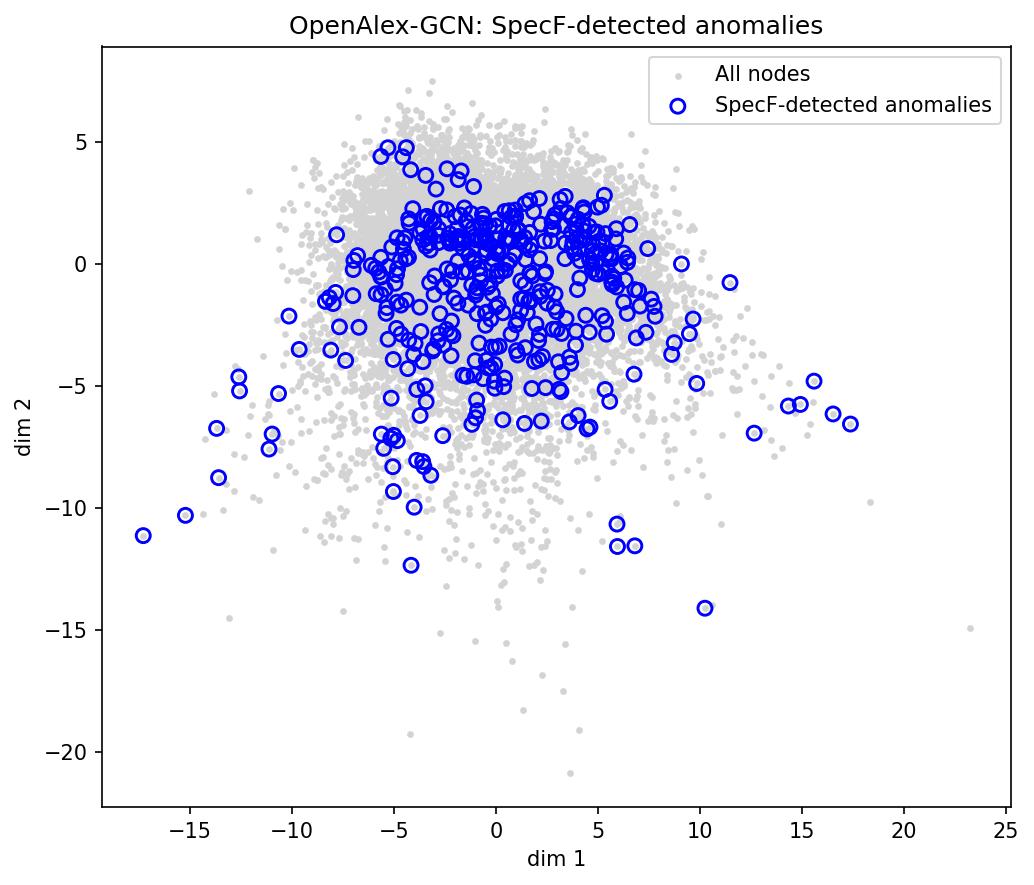

Saved plot to: /content/Results/SpecF_detected_anomalies.png


In [22]:
N = len(node_order)
specf_set = set(specf_anomalies)


# SpecF flagged nodes only (no TP/FN/FP without ground truth)
mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True   # SpecF-detected anomalies

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_detected_anomalies.png"

fig = plt.figure(figsize=(7, 6), dpi=150)

# background: all nodes
plt.scatter(X2[:, 0], X2[:, 1], s=5, color="lightgray", label="All nodes")

# SpecF anomalies
plt.scatter(
    X2[mask_anom, 0], X2[mask_anom, 1],
    s=45, edgecolors="blue", facecolors="none",
    linewidths=1.4, label="SpecF-detected anomalies"
)

plt.legend()
plt.title("OpenAlex-GCN: SpecF-detected anomalies")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.tight_layout()

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")


# Community Structure in PCA Space with SpecF Anomalies

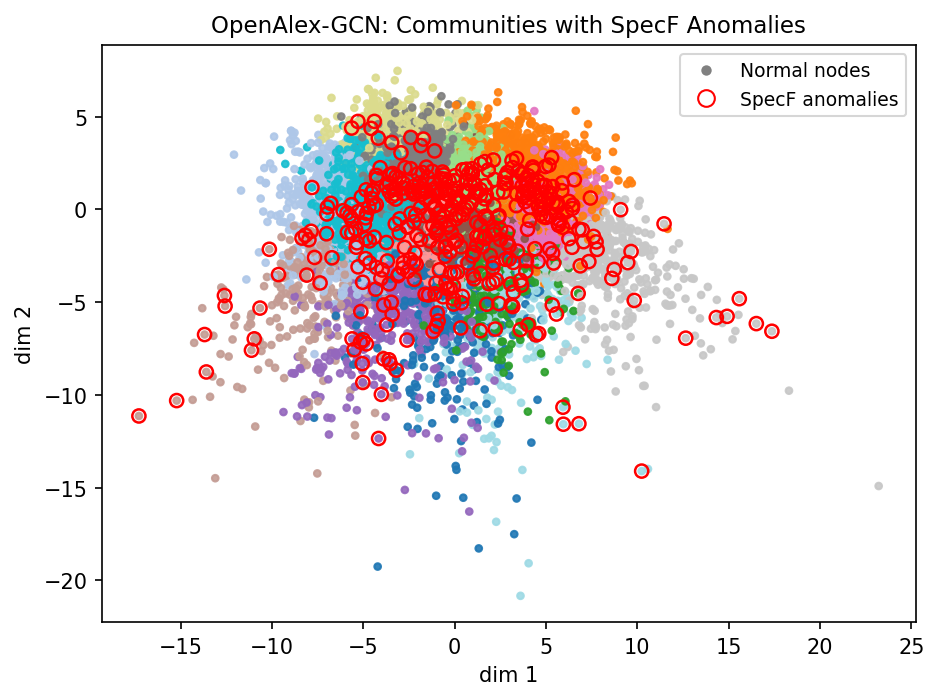

Saved plot to: /content/Results/Communities_with_SpecF_anomalies.png


In [23]:
comm_vec = np.array([clusters_dict[i] for i in range(len(node_order))], dtype=int)

mask = np.zeros(len(node_order), dtype=bool)
mask[specf_anomalies] = True

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "Communities_with_SpecF_anomalies.png"

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

# Communities
sc = ax.scatter(
    X2[:, 0], X2[:, 1],
    c=comm_vec,
    s=10,
    cmap="tab20",
    alpha=0.9
)

# SpecF anomalies
ax.scatter(
    X2[mask, 0], X2[mask, 1],
    s=40,
    edgecolors="red",
    facecolors="none",
    linewidths=1.2
)

# Legend for anomalies
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label='Normal nodes',
           markerfacecolor='gray', markersize=6),
    Line2D([0], [0], marker='o', color='red',
           label='SpecF anomalies',
           markerfacecolor='none', markersize=8, linestyle='None')
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    frameon=True,
    fontsize=9
)


# Labels
ax.set_title("OpenAlex-GCN: Communities with SpecF Anomalies", fontsize=11)
ax.set_xlabel("dim 1")
ax.set_ylabel("dim 2")

# Save
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")


# Anomalous nodes and their title, subject, community and score

In [24]:
data.titles = [node['title'] for node in all_nodes]

In [25]:
# --------------------------------------------------
# 1. OpenAlex domain mapping (Updated from Cora)
# --------------------------------------------------
openalex_subjects = {
    0: "Computer Science", 1: "Mathematics", 2: "Physics", 3: "Biology",
    4: "Chemistry", 5: "Medicine", 6: "Psychology",
    7: "Political Science", 8: "Sociology", 9: "Economics", 10: "History",
    11: "Materials Science", 12: "Engineering", 13: "Geology", 14: "Business"
}

# --------------------------------------------------
# 2. Dataset info
# --------------------------------------------------
labels = data.y.cpu().numpy()
N = data.num_nodes

# --------------------------------------------------
# 3. Full table (Using OpenAlex Titles)
# --------------------------------------------------
df_results = pd.DataFrame({
    "node_id": np.arange(N),
    "title": data.titles,  # Fetched during the data acquisition step
    "subject_id": labels,
    "subject_name": [openalex_subjects[int(l)] for l in labels],
    "community_id": [clusters_dict[i] for i in range(N)],
    "SpecF_score": [Y_scores[i] for i in range(N)]
})

# --------------------------------------------------
# 4. Keep ONLY anomalies and drop index
# --------------------------------------------------
df_anomalies = (
    df_results
    .iloc[specf_anomalies]
    .sort_values("SpecF_score", ascending=False)
    .reset_index(drop=True)
)

# --------------------------------------------------
# 5. Display
# --------------------------------------------------
pd.set_option('display.max_colwidth', None)
display(df_anomalies.head(10)) # Showing top 10 for brevity

# --------------------------------------------------
# 6. Export to Excel (Updated Filename)
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

df_anomalies_sorted = df_anomalies.sort_values(by="title", ascending=True)

# Updated filename to reflect OpenAlex and GCN
output_path = RESULTS_DIR / "OpenAlex_specf_anomalies_GCN.xlsx"

df_anomalies_sorted.to_excel(output_path, index=False)

print(f"Results saved to: {output_path.resolve()}")

node_id  \
0      291   
1     6504   
2     7741   
3     3447   
4       13   
5     7440   
6     2971   
7    11290   
8     4521   
9     5910   

                                                                                                                                                     title  \
0              The Strengthening the Reporting of Observational Studies in Epidemiology (STROBE) Statement: Guidelines for Reporting Observational Studies   
1                                                  Improving the quality of reports of meta-analyses of randomised controlled trials: the QUOROM statement   
2                                                                                                      Assessing the quality of controlled clinical trials   
3                                                                CONSORT 2010 Statement: updated guidelines for reporting parallel group randomised trials   
4                                                                 Preferred reporting items for systematic reviews and meta-analyses: the PRISMA statement   
5                                                               The Revised CONSORT Statement for Reporting Randomized Trials: Explanation and Elaboration   
6                                  The CONSORT statement: revised recommendations for improving the quality of reports of parallel-group randomised trials   
7                                  The CONSORT statement: revised recommendations for improving the quality of reports of parallel group randomized trials   
8  The PRISMA Statement for Reporting Systematic Reviews and Meta-Analyses of Studies That Evaluate Health Care Interventions: Explanation and Elaboration   
9                                               Strengthening the Reporting of Observational Studies in Epidemiology (STROBE): Explanation and Elaboration   

   subject_id      subject_name  community_id   SpecF_score  
0           0  Computer Science             6  1.370447e+09  
1           5          Medicine             6  1.214957e+09  
2           6        Psychology             6  1.209075e+09  
3           3           Biology             6  1.204825e+09  
4           0  Computer Science             6  1.186222e+09  
5           6        Psychology             6  1.161485e+09  
6           2           Physics             6  1.153816e+09  
7           9         Economics             6  1.134720e+09  
8           4         Chemistry             6  1.078750e+09  
9           5          Medicine             6  1.028640e+09

Results saved to: /content/Results/OpenAlex_specf_anomalies_GCN.xlsx


# Count NORMAL vs ANOMALOUS per subject

In [26]:
# 1. Use the OpenAlex mapping (Ensure this matches your domain IDs)
openalex_subjects = {
    0: "Computer Science", 1: "Mathematics", 2: "Physics", 3: "Biology",
    4: "Chemistry", 5: "Medicine", 6: "Psychology",
    7: "Political Science", 8: "Sociology", 9: "Economics", 10: "History",
    11: "Materials Science", 12: "Engineering", 13: "Geology", 14: "Business"
}

stats = defaultdict(lambda: {
    "total": 0,
    "normal": 0,
    "anomalous": 0
})

# 2. Iterate through nodes and count
for i in range(data.num_nodes):
    lab = int(df_results.loc[i, "subject_id"])   # <-- changed
    stats[lab]["total"] += 1
    if i in specf_set:
        stats[lab]["anomalous"] += 1
    else:
        stats[lab]["normal"] += 1

print("\nClass-wise normal vs anomalous nodes (SpecF):\n")
# Adjusted header formatting for better alignment
print(f"{'Subject':25s} | {'Total':>6s} | {'Normal':>7s} | {'Anom':>5s} | {'Anom %':>7s}")
print("-" * 65)

# 3. Print results using the OpenAlex domain names
for lab in sorted(stats.keys()):
    s = stats[lab]
    total = s["total"]
    anom = s["anomalous"]
    normal = s["normal"]
    pct = 100.0 * anom / total if total > 0 else 0.0

    # Map the integer label to the OpenAlex string name
    subject_name = openalex_subjects.get(lab, f"Unknown ({lab})")

    print(f"{subject_name:25s} | "
          f"{total:6d} | {normal:7d} | {anom:5d} | {pct:6.2f}%")


Class-wise normal vs anomalous nodes (SpecF):

Subject                   |  Total |  Normal |  Anom |  Anom %
-----------------------------------------------------------------
Computer Science          |   1000 |     967 |    33 |   3.30%
Mathematics               |   1188 |    1148 |    40 |   3.37%
Physics                   |   1163 |    1128 |    35 |   3.01%
Biology                   |   1165 |    1136 |    29 |   2.49%
Chemistry                 |   1181 |    1141 |    40 |   3.39%
Medicine                  |   1137 |    1083 |    54 |   4.75%
Psychology                |   1035 |    1008 |    27 |   2.61%
Political Science         |   1166 |    1138 |    28 |   2.40%
Sociology                 |   1154 |    1144 |    10 |   0.87%
Economics                 |   1119 |    1100 |    19 |   1.70%
History                   |   1088 |    1078 |    10 |   0.92%
Materials Science         |   1031 |     988 |    43 |   4.17%
Engineering               |   1056 |    1043 |    13 |   1.23%
Geol

**visualize**

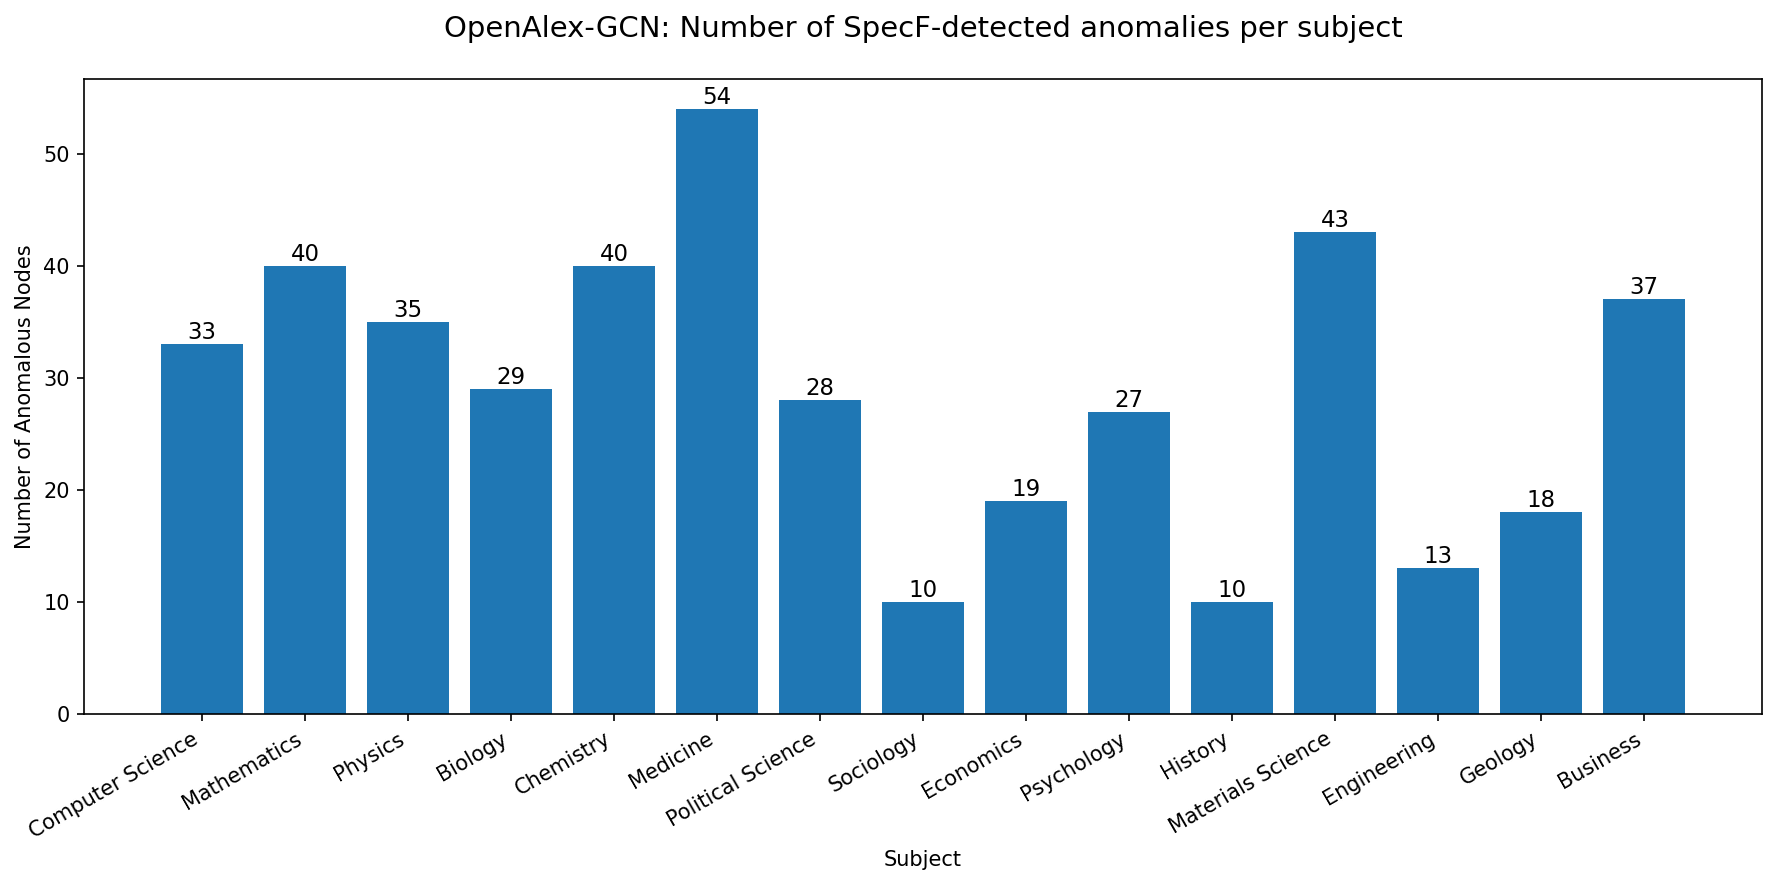

In [27]:
# ----------------------------------
# 1. Build per-subject stats (OpenAlex Domains)
# ----------------------------------
all_subjects = list(domains.values())  # 19 subjects, in your desired order
# We check which nodes are in the specf_set to mark them as anomalies

stats_subj = (
    df_results
    .assign(is_specf_anom=df_results["node_id"].isin(specf_set))
    .groupby("subject_name")["is_specf_anom"]
    .agg(total="count", anom="sum")
    .reindex(all_subjects, fill_value=0)   # <-- add missing subjects with 0
    .reset_index()
    .rename(columns={"index": "subject_name"})
)


# ----------------------------------
# 2. Plot anomaly COUNTS
# ----------------------------------
fig = plt.figure(figsize=(12, 6), dpi=150)

# Using a distinct color to differentiate from the previous Cora plots
bars = plt.bar(stats_subj["subject_name"], stats_subj["anom"])

# Add numbers on top of bars
for bar, val in zip(bars, stats_subj["anom"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        str(int(val)),
        ha="center",
        va="bottom",
        fontsize=11,
    )

# ----------------------------------
# 3. Formatting
# ----------------------------------
plt.xlabel("Subject")
plt.ylabel("Number of Anomalous Nodes")
plt.title("OpenAlex-GCN: Number of SpecF-detected anomalies per subject", fontsize=14, pad=20)
plt.xticks(rotation=30, ha="right")
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

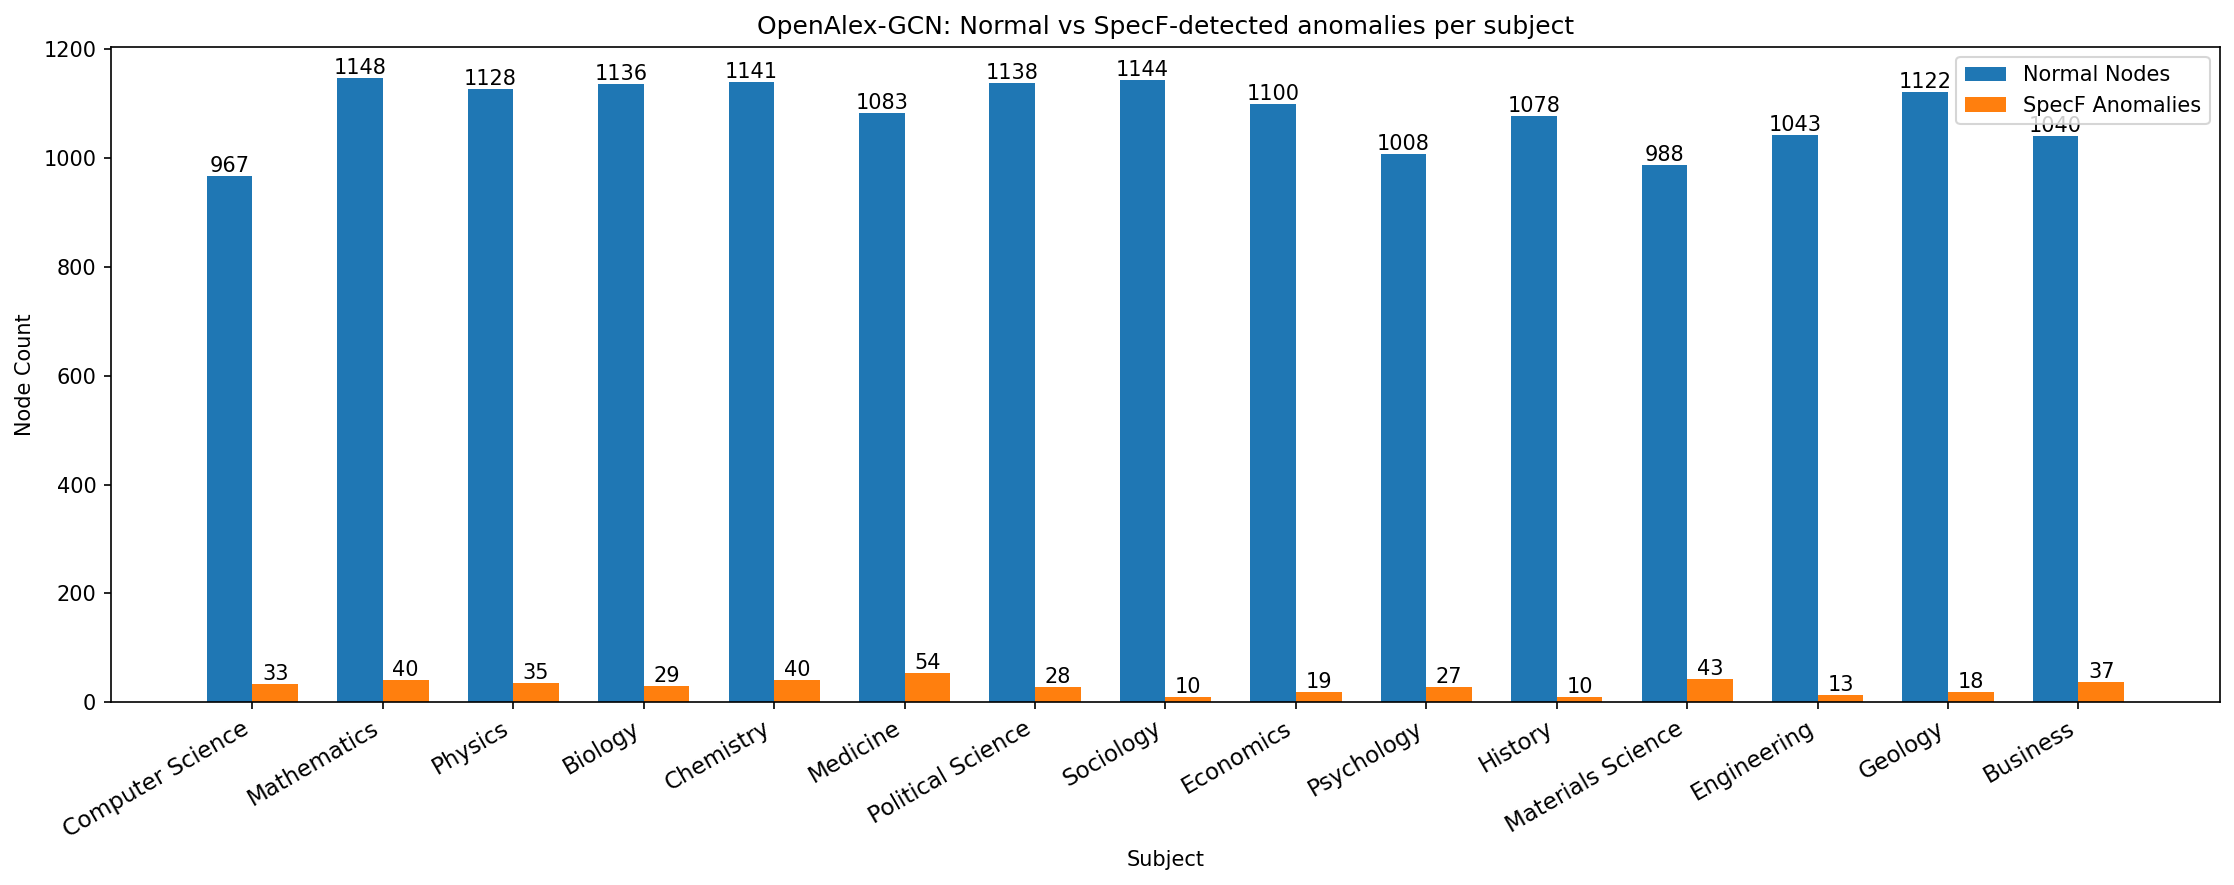

Saved plot to: /content/Results/Normal_vs_SpecF_anomalies_per_subject.png


In [28]:
# 1. Calculate normal count (Total - Anomalies)
stats_subj["normal"] = stats_subj["total"] - stats_subj["anom"]

x = np.arange(len(stats_subj))
width = 0.35

# --------------------------------------------------
# Results folder setup
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Updated filename for OpenAlex context
out_png = RESULTS_DIR / "Normal_vs_SpecF_anomalies_per_subject.png"

# --------------------------------------------------
# Plot Construction
# --------------------------------------------------
# Using subplots for cleaner axis management
fig, ax = plt.subplots(figsize=(15, 6), dpi=150)

# We use distinct colors: Grey for normal (background) and Red for anomalies (signal)
bars_normal = ax.bar(x - width/2, stats_subj["normal"], width, label="Normal Nodes")
bars_anom   = ax.bar(x + width/2, stats_subj["anom"],   width, label="SpecF Anomalies")

# -------------------------------------------------
# Add text labels on top of bars
# -------------------------------------------------
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=10,
            )

add_labels(bars_normal)
add_labels(bars_anom)

# -------------------------------------------------
# Formatting and Labels
# -------------------------------------------------
ax.set_xticks(x)
ax.set_xticklabels(stats_subj["subject_name"], rotation=30, ha="right", fontsize=11)

ax.set_xlabel("Subject")
ax.set_ylabel("Node Count")
ax.set_title("OpenAlex-GCN: Normal vs SpecF-detected anomalies per subject")
ax.legend()

# Optional: If the 'Normal' bars are so large they hide the anomalies,
# uncomment the line below to use a log scale:
# ax.set_yscale('log')

plt.tight_layout()

# Save the plot
plt.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")

# Count NORMAL vs ANOMALOUS per community

In [29]:
# --------------------------------------------------
# 1. Initialize stats for communities
# --------------------------------------------------
stats_comm = defaultdict(lambda: {
    "total": 0,
    "normal": 0,
    "anomalous": 0
})

# --------------------------------------------------
# 2. Iterate through results using node_id for safety
# --------------------------------------------------
for _, row in df_results.iterrows():
    node_idx = int(row["node_id"])
    comm_id = int(row["community_id"])

    stats_comm[comm_id]["total"] += 1

    # Check if this specific node index is in the anomaly set
    if node_idx in specf_set:
        stats_comm[comm_id]["anomalous"] += 1
    else:
        stats_comm[comm_id]["normal"] += 1

# --------------------------------------------------
# 3. Print the Community Report
# --------------------------------------------------
print("\nCommunity-wise normal vs anomalous nodes (SpecF):\n")
# Adjusted spacing to handle larger datasets
print(f"{'Community ID':>12s} | {'Total':>7s} | {'Normal':>7s} | {'Anom':>6s} | {'Anom %':>8s}")
print("-" * 60)

for comm in sorted(stats_comm.keys()):
    s = stats_comm[comm]
    total = s["total"]
    anom = s["anomalous"]
    normal = s["normal"]
    pct = 100.0 * anom / total if total > 0 else 0.0

    print(f"{comm:12d} | "
          f"{total:7d} | {normal:7d} | {anom:6d} | {pct:7.2f}%")


Community-wise normal vs anomalous nodes (SpecF):

Community ID |   Total |  Normal |   Anom |   Anom %
------------------------------------------------------------
           0 |     517 |     506 |     11 |    2.13%
           1 |     988 |     981 |      7 |    0.71%
           2 |     963 |     933 |     30 |    3.12%
           3 |     656 |     627 |     29 |    4.42%
           4 |    4077 |    4020 |     57 |    1.40%
           5 |    1262 |    1212 |     50 |    3.96%
           6 |     371 |     350 |     21 |    5.66%
           7 |    1540 |    1510 |     30 |    1.95%
           8 |     264 |     247 |     17 |    6.44%
           9 |    1500 |    1452 |     48 |    3.20%
          10 |    1650 |    1610 |     40 |    2.42%
          11 |     464 |     443 |     21 |    4.53%
          12 |    1057 |    1040 |     17 |    1.61%
          13 |     964 |     929 |     35 |    3.63%
          14 |     427 |     404 |     23 |    5.39%


Vizualize

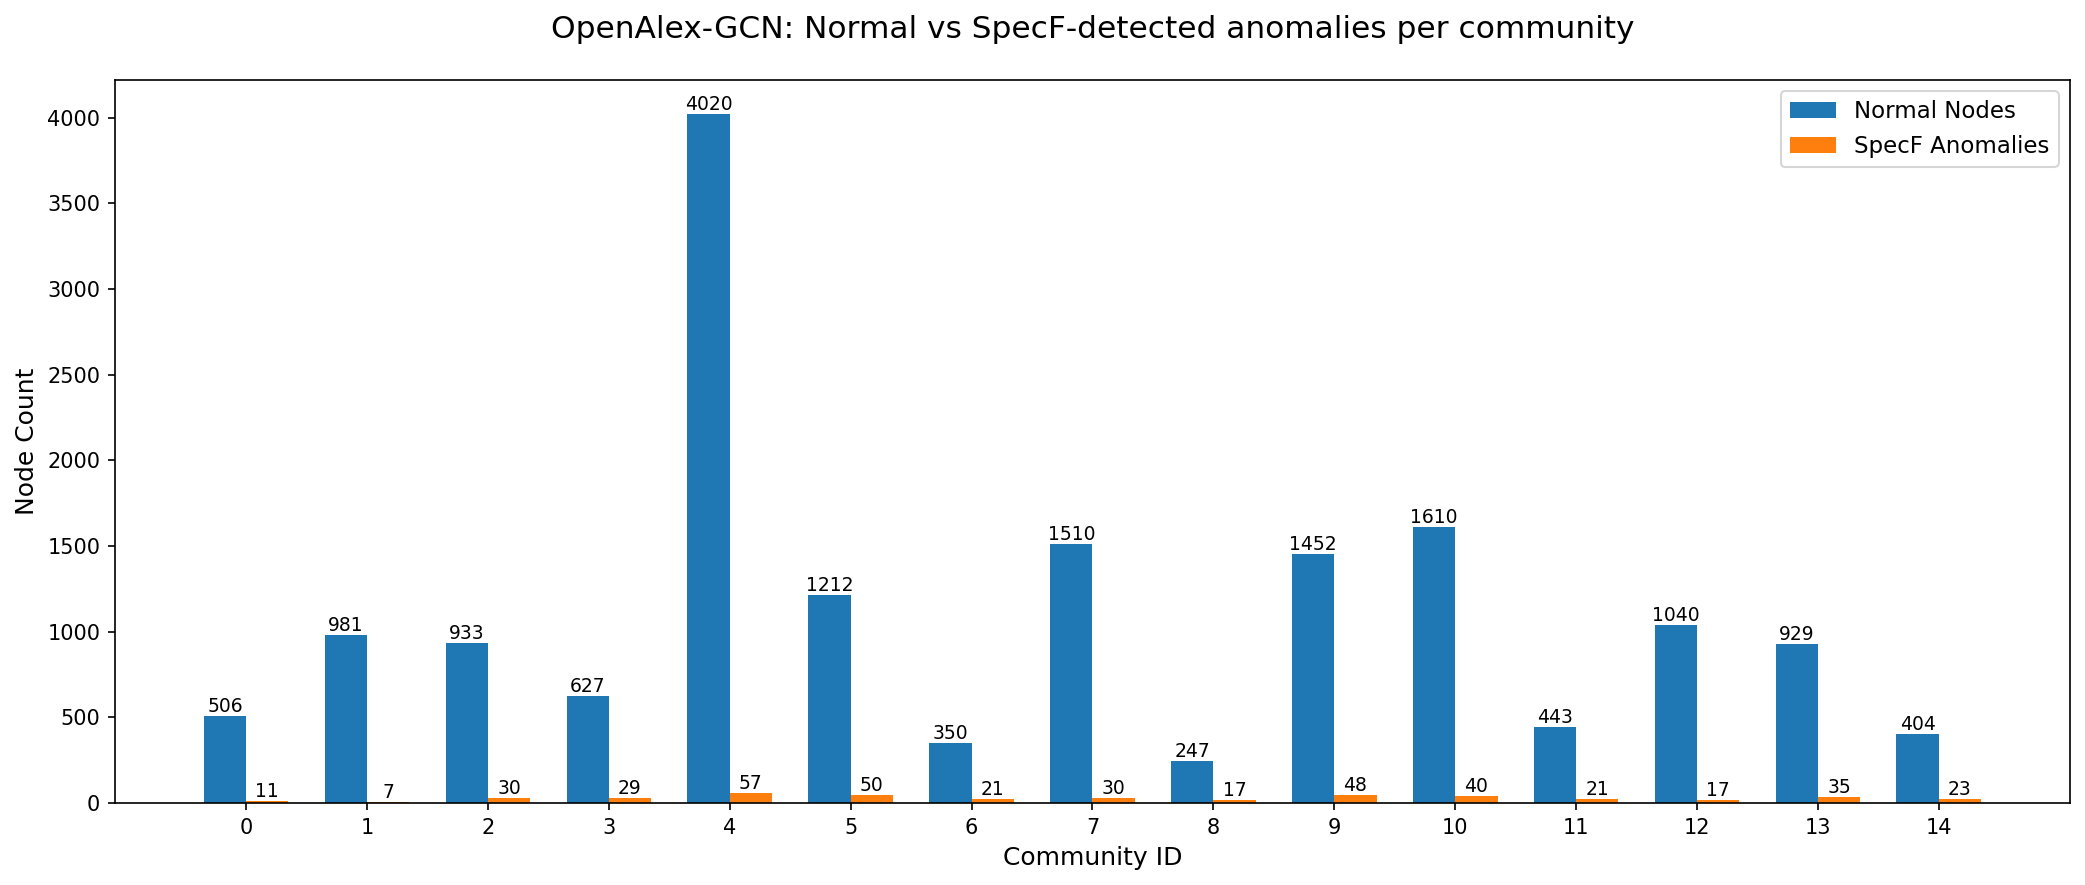

Community comparison plot saved to: /content/Results/Normal_vs_SpecF_anomalies_per_community.png


In [30]:
# 1. Prepare data from your stats dictionary (ensure it's stats_comm if you used the previous block)
comms = sorted(stats_comm.keys())
normal_vals = [stats_comm[c]["normal"] for c in comms]
anom_vals   = [stats_comm[c]["anomalous"] for c in comms]

x = np.arange(len(comms))
width = 0.35

# --------------------------------------------------
# 2. Results folder setup
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "Normal_vs_SpecF_anomalies_per_community.png"

# --------------------------------------------------
# 3. Plot Construction
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6), dpi=150)

# Consistency: Grey for normal, Red for anomalies
bars_normal = ax.bar(x - width/2, normal_vals, width, label="Normal Nodes")
bars_anom   = ax.bar(x + width/2, anom_vals,   width, label="SpecF Anomalies")

# -------------------------------------------------
# 4. Add text labels on top of bars
# -------------------------------------------------
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9,
            )

add_bar_labels(bars_normal)
add_bar_labels(bars_anom)

# -------------------------------------------------
# 5. Formatting
# -------------------------------------------------
ax.set_xticks(x)
ax.set_xticklabels(comms, fontsize=10)

ax.set_xlabel("Community ID", fontsize=12)
ax.set_ylabel("Node Count", fontsize=12)
ax.set_title("OpenAlex-GCN: Normal vs SpecF-detected anomalies per community", fontsize=15, pad=20)
ax.legend(fontsize=11)

# Optional: Uncomment if anomaly bars are too small to see relative to normal bars
# ax.set_yscale('log')

plt.tight_layout()

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Community comparison plot saved to: {out_png.resolve()}")

# Visualize ANOMALOUS nodes per community

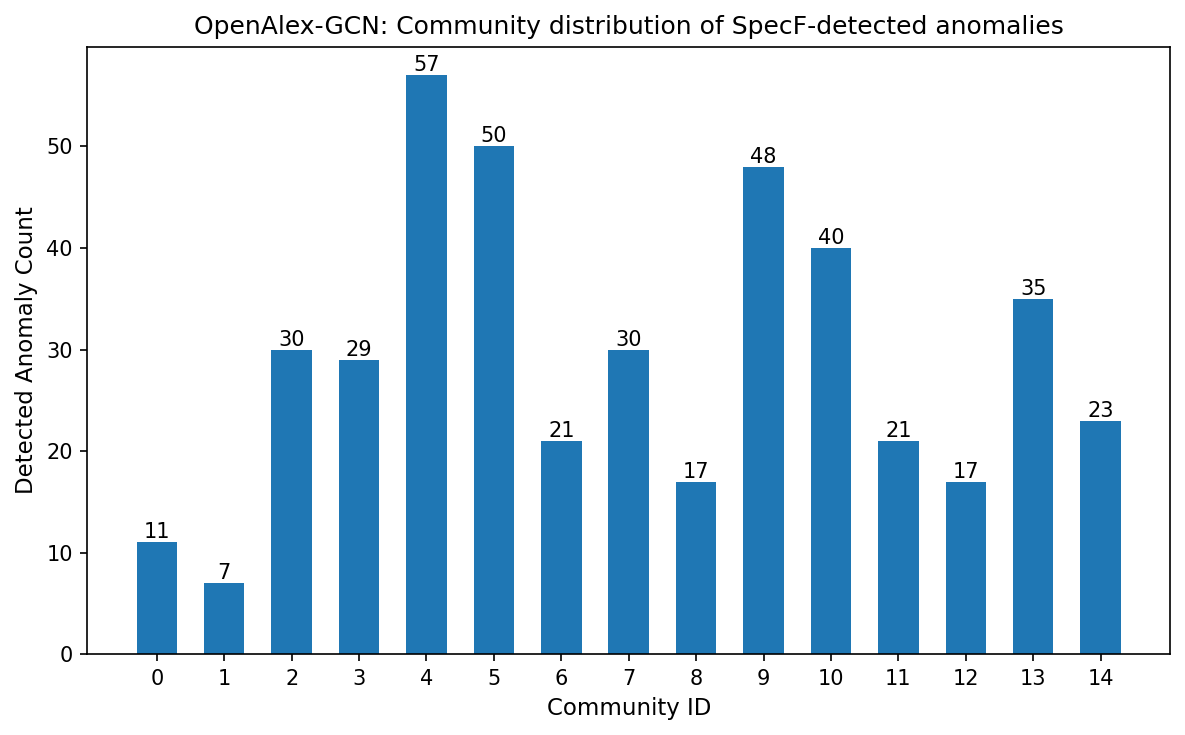

In [31]:
# --------------------------------------------------
# 1. Calculate distribution of anomalies across communities
# --------------------------------------------------
# Mapping each node index in the anomaly set to its discovered community
detected_comms = [clusters_dict[n] for n in specf_set]
detected_cnt = Counter(detected_comms)

# Sort communities numerically for the x-axis
all_comms = sorted(detected_cnt.keys())
x = np.arange(len(all_comms))
vals = [detected_cnt[c] for c in all_comms]

# --------------------------------------------------
# 2. Plotting
# --------------------------------------------------
plt.figure(figsize=(8, 5), dpi=150)

# Use the red color established for anomalies in previous plots
bars = plt.bar(x, vals, width=0.6)

# Add numbers on top of each bar for clarity
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

# --------------------------------------------------
# 3. Formatting
# --------------------------------------------------
plt.xticks(x, all_comms)
plt.xlabel("Community ID", fontsize=11)
plt.ylabel("Detected Anomaly Count", fontsize=11)
plt.title("OpenAlex-GCN: Community distribution of SpecF-detected anomalies")
plt.tight_layout()

# Save the figure
plt.show()



# Per-community distribution of SpecF spectral deviation scores

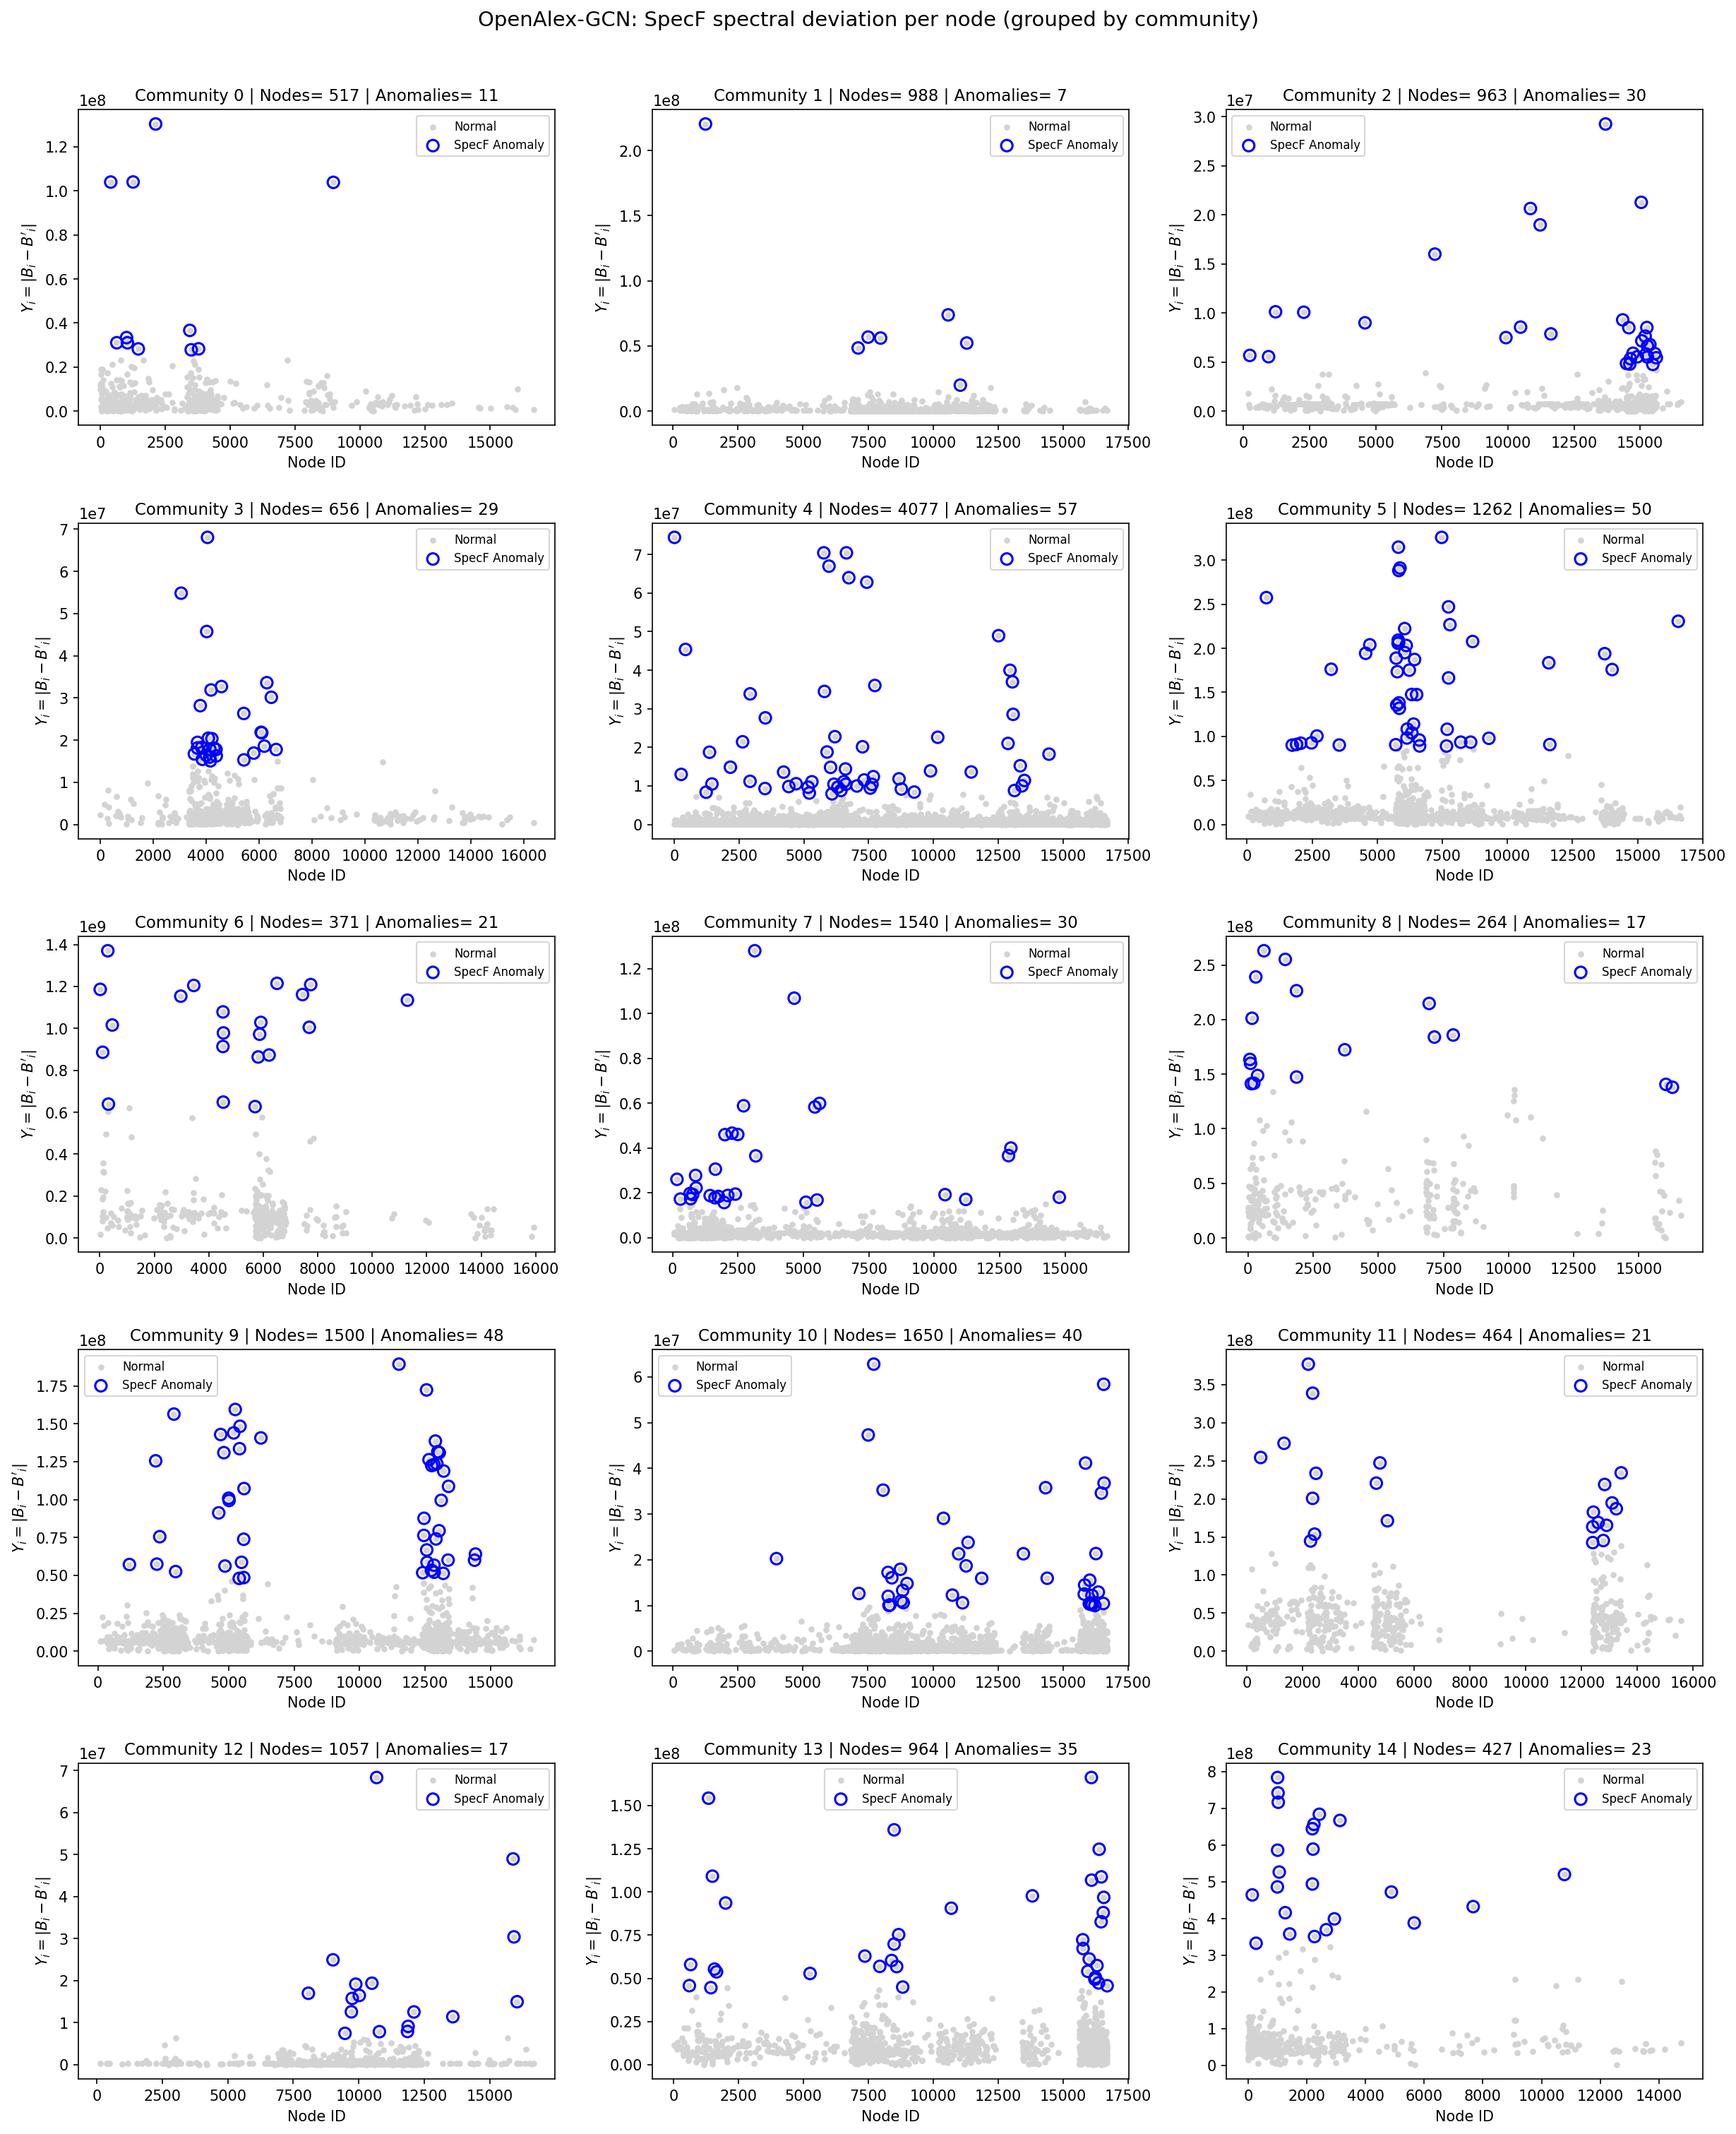

plot saved to: /content/Results/SpecF_scores_per_community.png


In [32]:
# -------------------------------------------------
# 1. Prepare data (Assuming N ~ 7,000+)
# -------------------------------------------------
N = len(B)
vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)
comm_ids = np.array([clusters_dict[i] for i in range(N)])
specf_set = set(specf_anomalies)

# Sort all unique community IDs
all_comms = np.sort(np.unique(comm_ids))

# -------------------------------------------------
# 2. Grid Layout Settings
# -------------------------------------------------
cols = 3
rows = math.ceil(len(all_comms) / cols)

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Updated filename for OpenAlex
out_png = RESULTS_DIR / "SpecF_scores_per_community.png"

# -------------------------------------------------
# 3. Multi-Subplot Generation
# -------------------------------------------------
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4), dpi=150)
axes = np.array(axes).reshape(-1) # Flatten grid for easy indexing

for ax_i, c in enumerate(all_comms):
    ax = axes[ax_i]

    # Find nodes belonging to this community
    idx = np.where(comm_ids == c)[0]
    # Identify which of those community nodes are flagged as anomalies
    idx_anom = np.array([i for i in idx if int(i) in specf_set], dtype=int)

    # Plot normal nodes (Grey background)
    ax.scatter(idx, vals_Y[idx], s=10, color = "lightgray", label="Normal")

    # Highlight anomalies (Red circles)
    if len(idx_anom) > 0:
        ax.scatter(
            idx_anom,
            vals_Y[idx_anom],
            s=60,
            facecolors="none",
            edgecolors="blue", # Red theme
            linewidths=1.5,
            label="SpecF Anomaly"
        )

    # Subplot Titles and Styling
    ax.set_title(
        f"Community {c} | Nodes= {len(idx)} | Anomalies= {len(idx_anom)}",
        fontsize=11
    )
    ax.set_xlabel("Node ID")
    ax.set_ylabel(r"$Y_i = |B_i - B'_i|$")
    #ax.grid(True, linestyle=':', alpha=0.4)
    ax.legend(fontsize=8)

# Hide any empty subplots in the grid
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

# Overall Figure title
fig.suptitle(
    "OpenAlex-GCN: SpecF spectral deviation per node (grouped by community)",
    fontsize=14, y=1.005
)

fig.tight_layout()

# 4. Save and Export
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"plot saved to: {out_png.resolve()}")

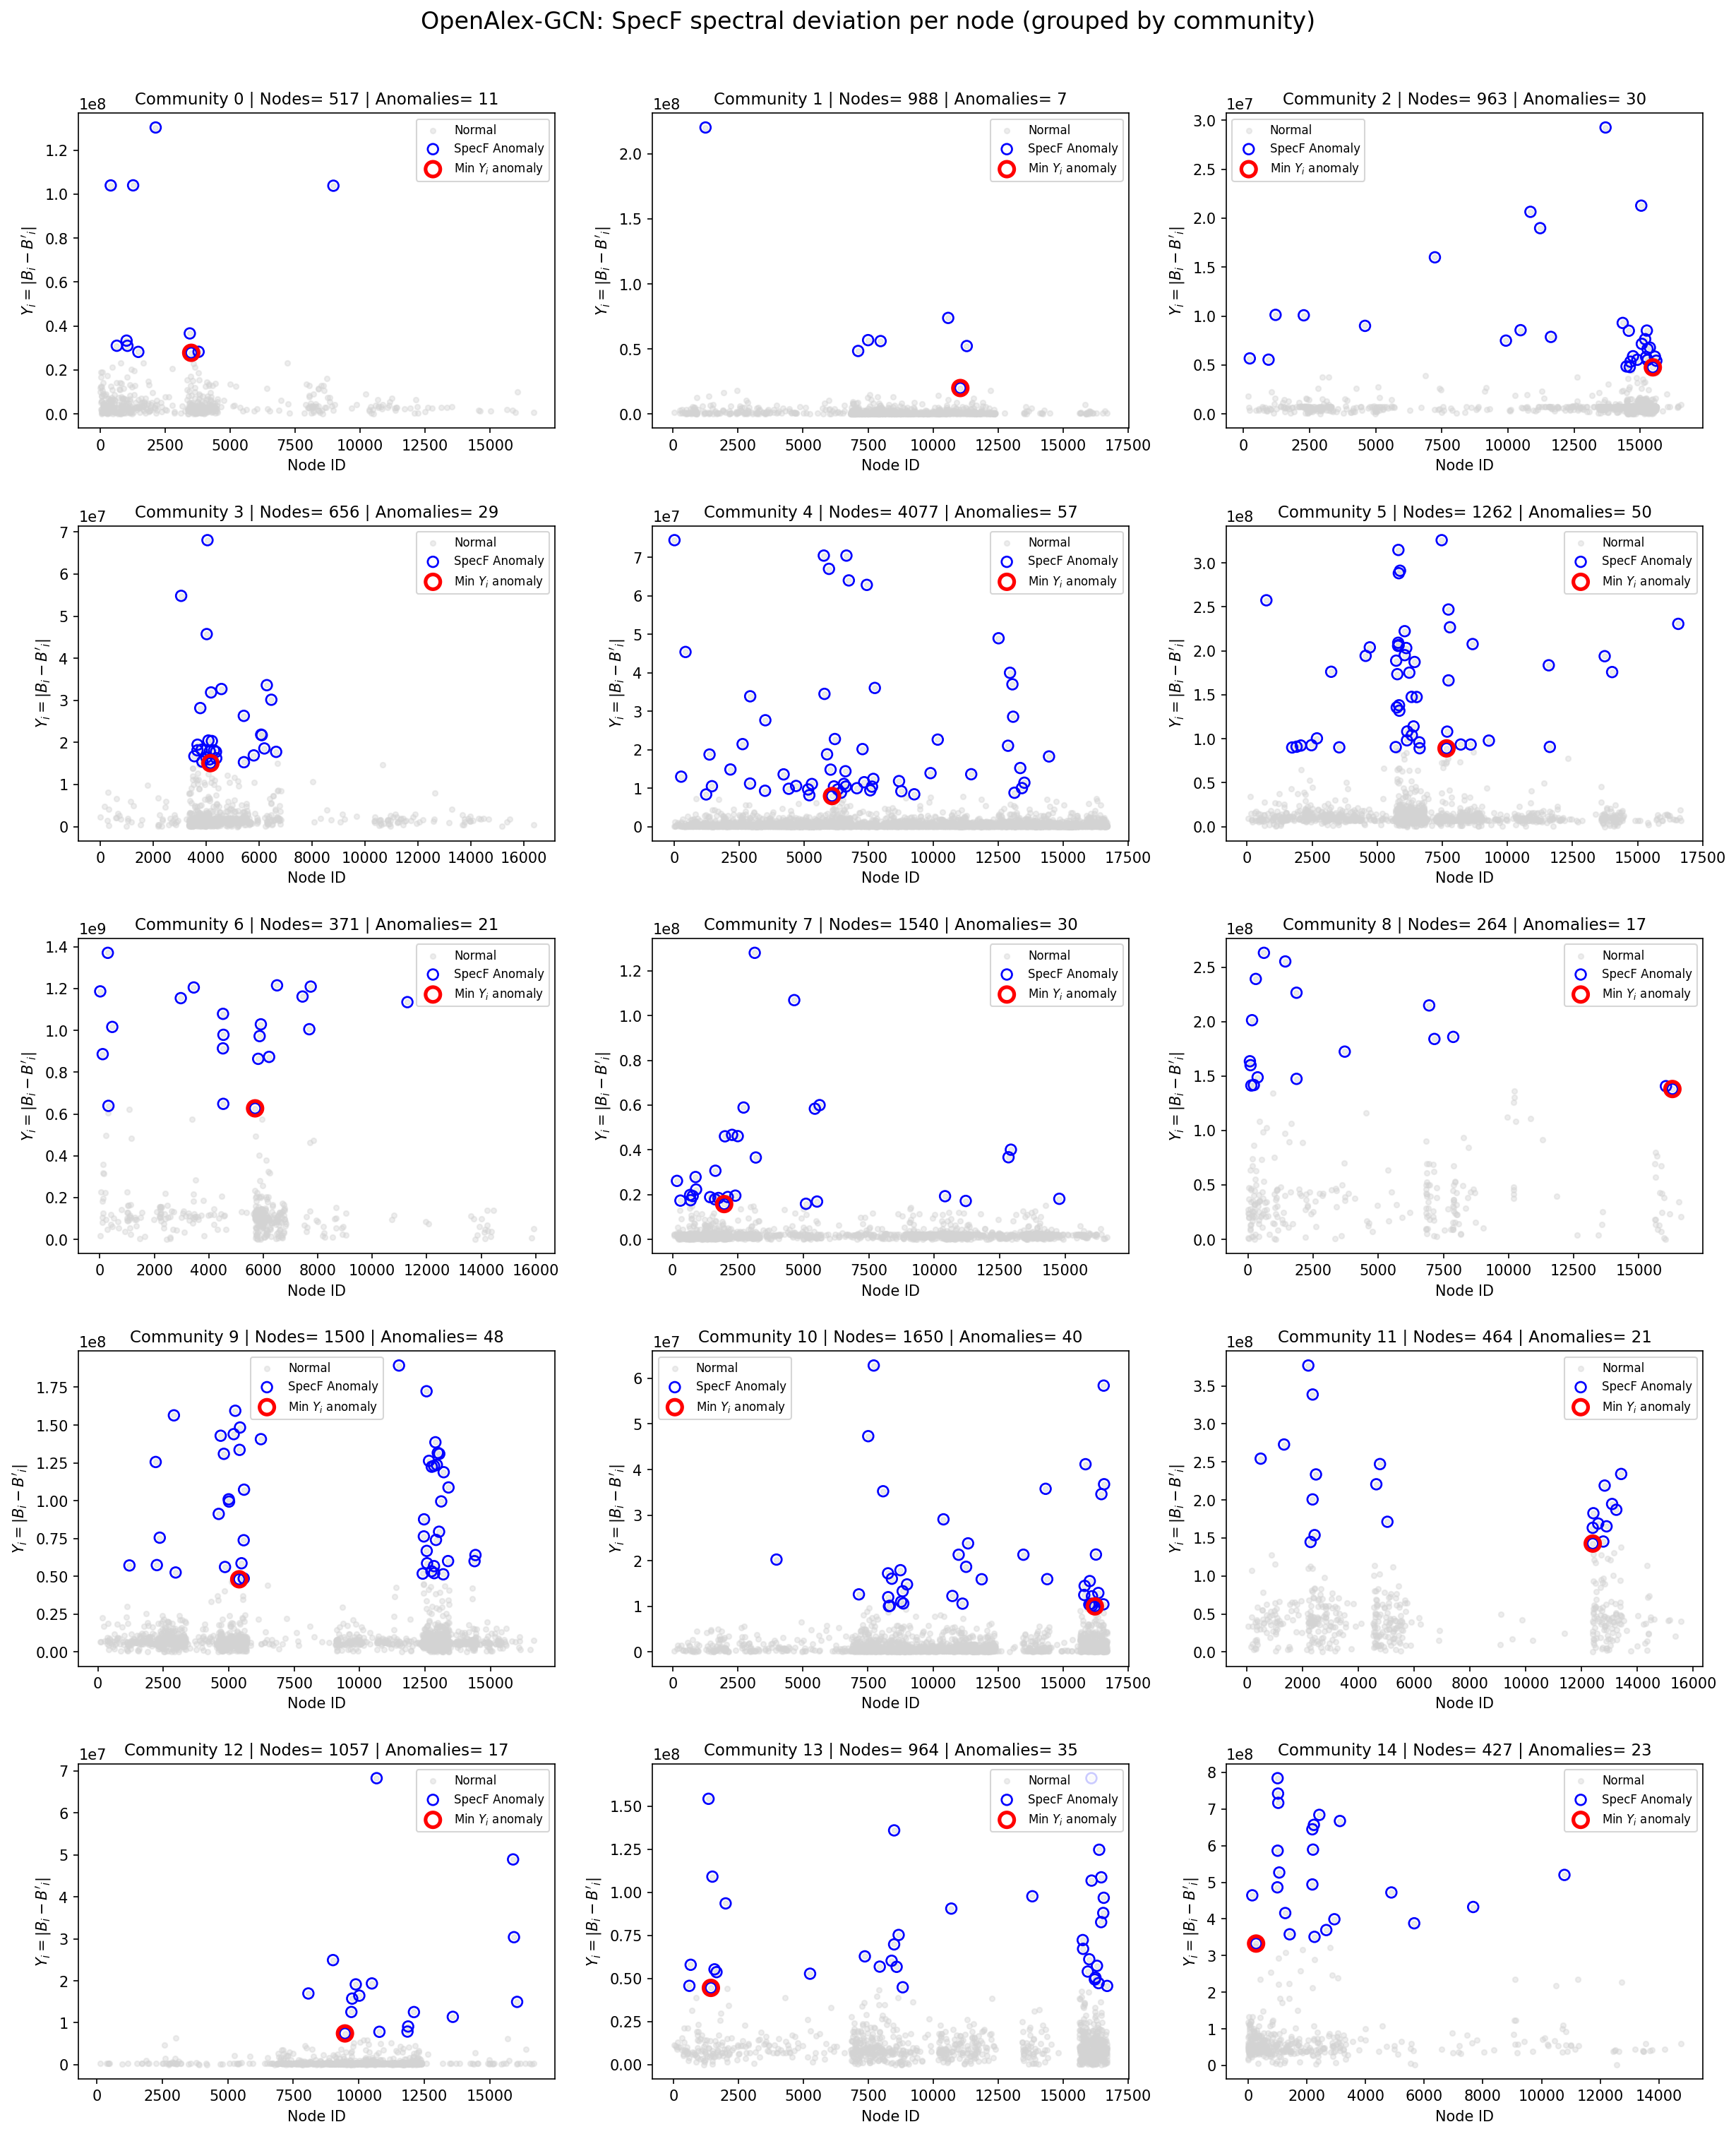

Saved figure to: /content/Results/SpecF_scores_per_community_minYi_highlighted.png


In [33]:
# -------------------------------------------------
# 1. Prepare data (N ~ 16,000+ for OpenAlex)
# -------------------------------------------------
N = len(B)

# Ensure numeric types and mapping
vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)
comm_ids = np.array([clusters_dict[i] for i in range(N)], dtype=int)
specf_set = set(map(int, specf_anomalies))

all_comms = np.sort(np.unique(comm_ids))

# -------------------------------------------------
# 2. Plot settings
# -------------------------------------------------
cols = 3
rows = math.ceil(len(all_comms) / cols)

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Updated filename for OpenAlex
out_png = RESULTS_DIR / "SpecF_scores_per_community_minYi_highlighted.png"

# -------------------------------------------------
# 3. Plotting Grid
# -------------------------------------------------
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4), dpi=150)
axes = np.array(axes).reshape(-1)

for ax_i, c in enumerate(all_comms):
    ax = axes[ax_i]

    # Find nodes in this community
    idx = np.where(comm_ids == c)[0]
    # Identify anomalies in this community
    idx_anom = np.array([i for i in idx if int(i) in specf_set], dtype=int)

    # A. Plot all normal nodes (Subtle Grey)
    ax.scatter(idx, vals_Y[idx], s=12, color="lightgray", alpha=0.4, label="Normal")

    if len(idx_anom) > 0:
        # B. Plot all anomalies (Blue circles as requested)
        ax.scatter(
            idx_anom,
            vals_Y[idx_anom],
            s=50,
            facecolors="none",
            edgecolors="blue",
            linewidths=1.3,
            label="SpecF Anomaly"
        )

        # C. Highlight the "Borderline" anomaly (Smallest Yi)
        min_pos = np.argmin(vals_Y[idx_anom])
        min_node = idx_anom[min_pos]

        ax.scatter(
            [min_node],
            [vals_Y[min_node]],
            s=100,
            facecolors="none",
            edgecolors="red",
            linewidths=2.5,
            label="Min $Y_i$ anomaly"
        )

    # Subplot Titles and Styling
    ax.set_title(
        f"Community {c} | Nodes= {len(idx)} | Anomalies= {len(idx_anom)}",
        fontsize=11
    )
    ax.set_xlabel("Node ID")
    ax.set_ylabel(r"$Y_i = |B_i - B'_i|$")
   # ax.grid(True, linestyle=':', alpha=0.3)

    # Avoid legend clutter: only show unique labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=8)

# Remove unused subplots
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

# Overall Figure title
fig.suptitle(
    "OpenAlex-GCN: SpecF spectral deviation per node (grouped by community)",
    fontsize=16, y=1.005
)

fig.tight_layout()

# 4. Save and Export
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved figure to: {out_png.resolve()}")

# visualization of SpecF-detected anomalies per community

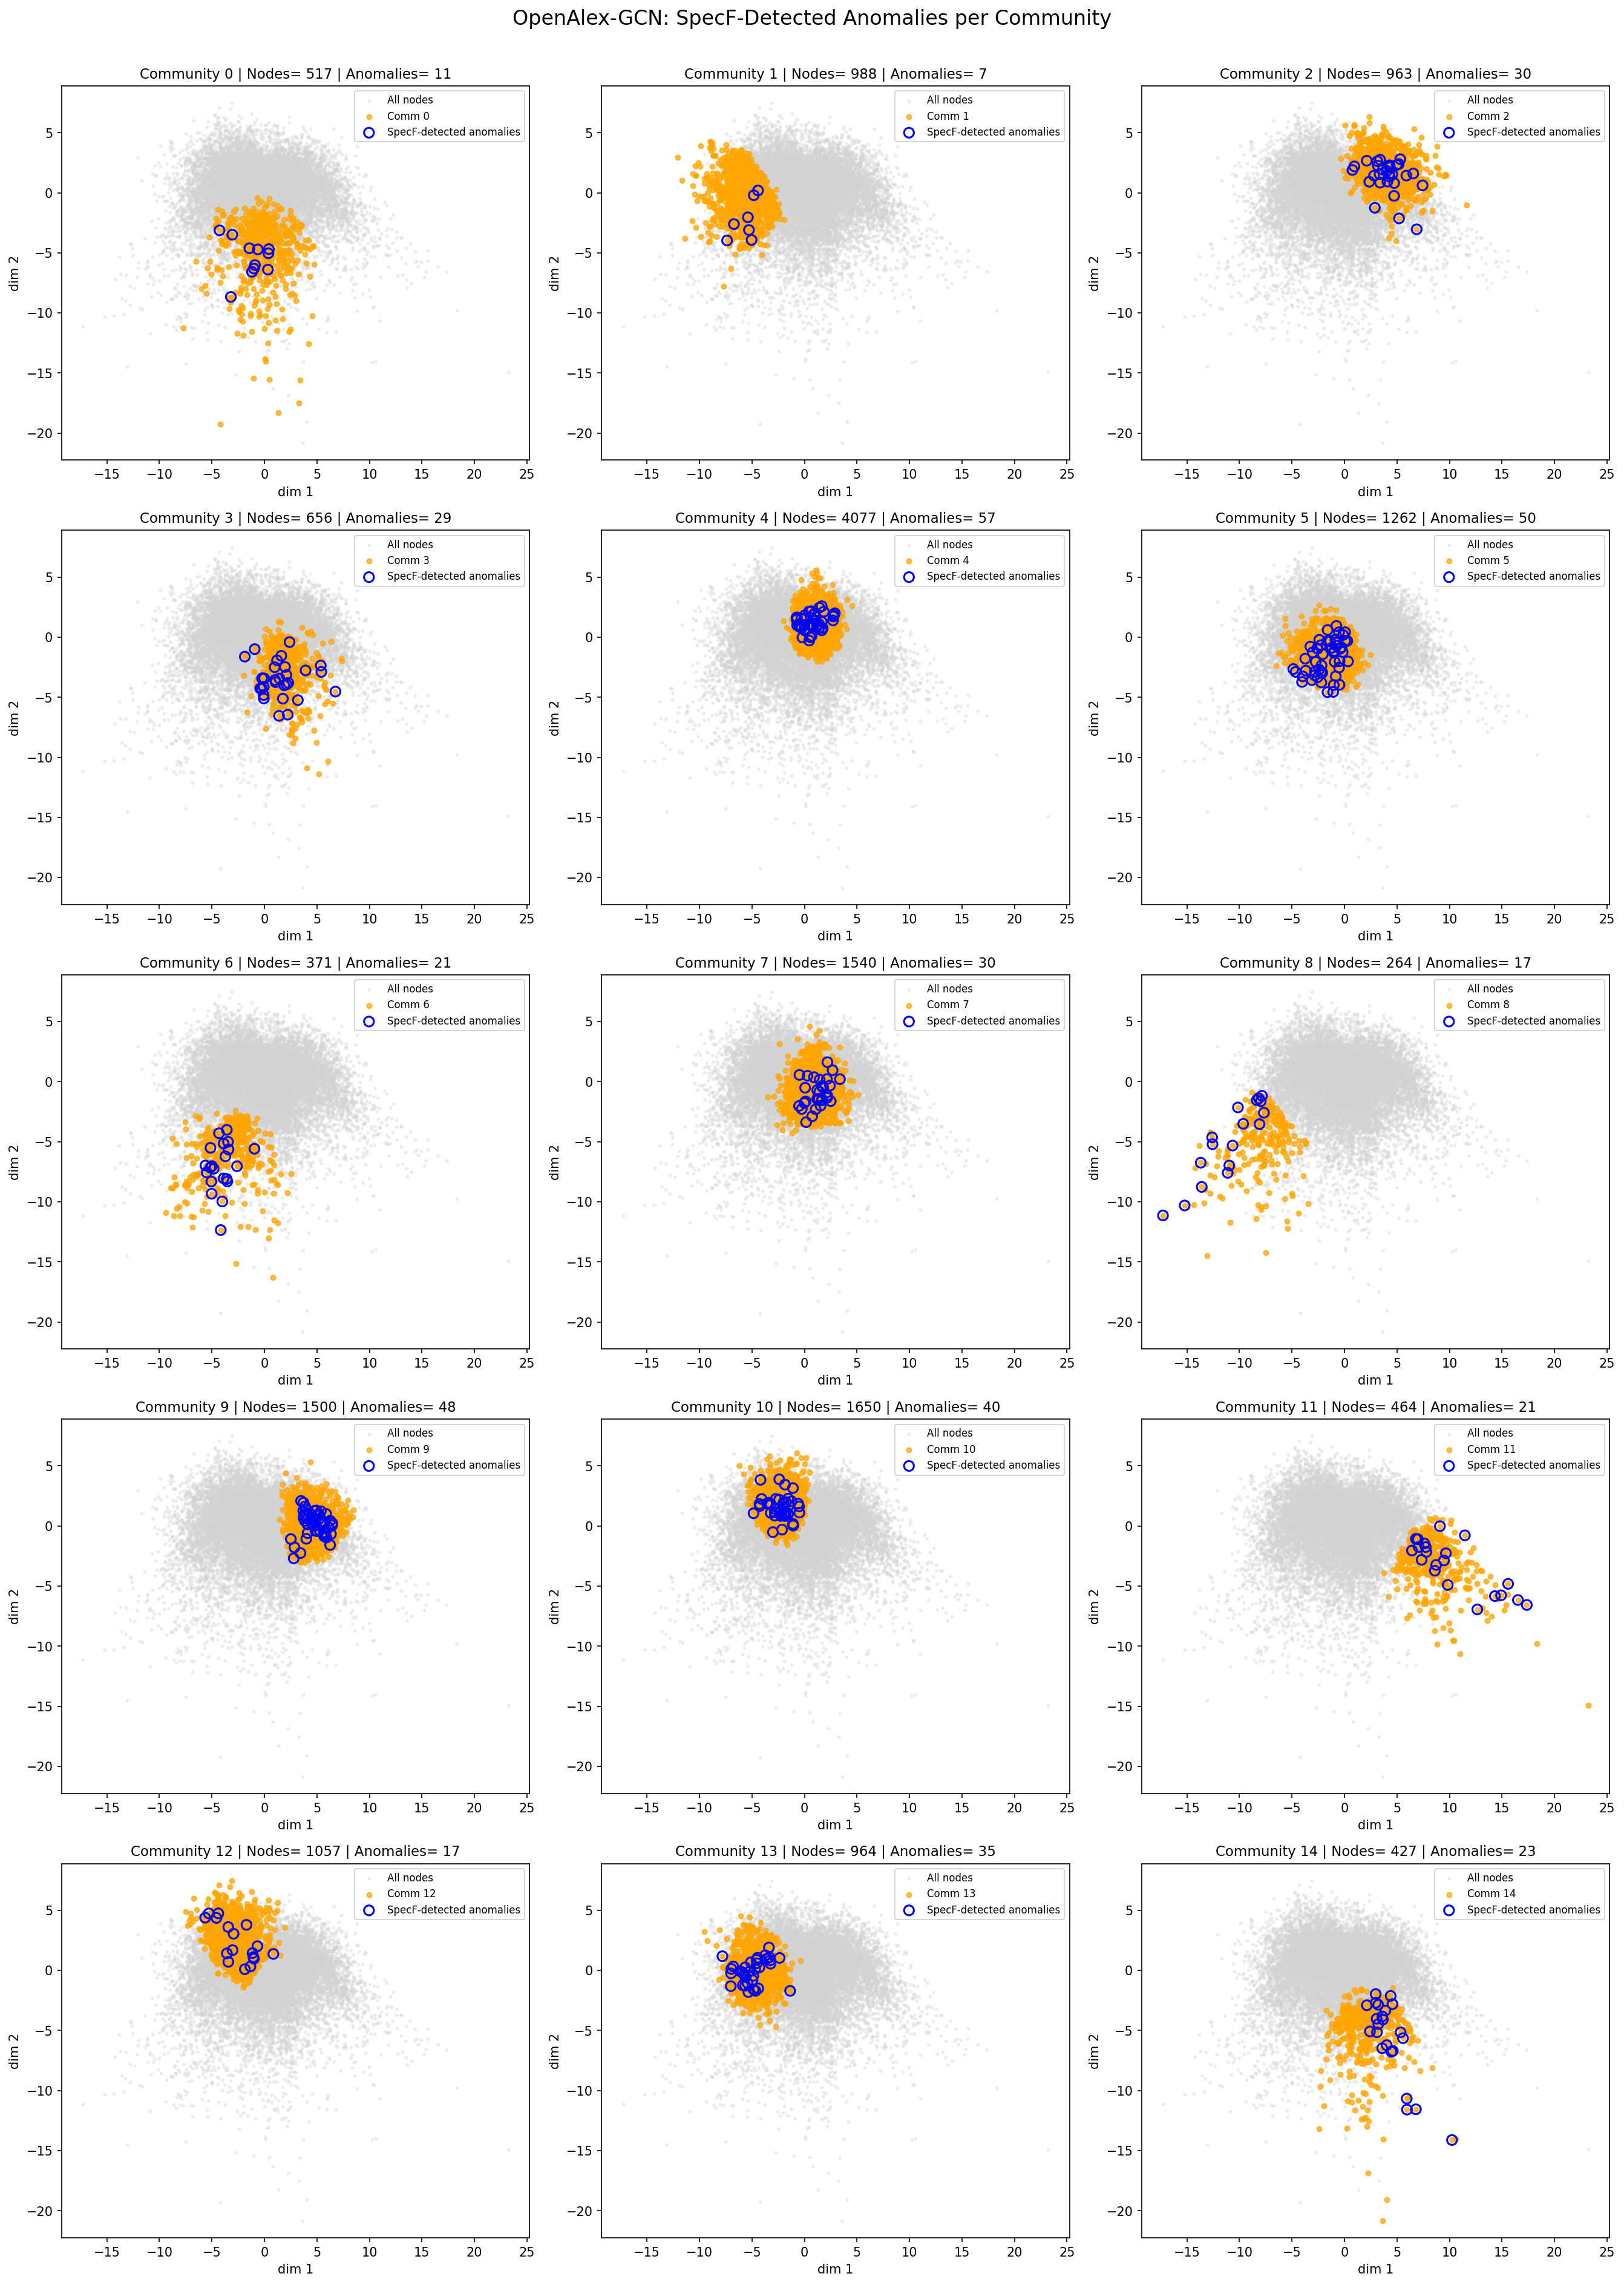

plot saved to: /content/Results/SpecF_detected_anomalies_per_community.png


In [34]:
# --------------------------------------------------
# 1. Prepare Masks and Metadata
# --------------------------------------------------
# Assuming N is the number of nodes in your OpenAlex subset
N = len(data.titles)
specf_set = set(map(int, specf_anomalies))

# SpecF anomaly mask
mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True

# Community mapping (aligned with X2 indexing)
comm_ids = np.array([clusters_dict[i] for i in range(N)])
all_comms = np.sort(np.unique(comm_ids))

# Layout settings
cols = 3
rows = math.ceil(len(all_comms) / cols)

# --------------------------------------------------
# 2. Results Folder Setup
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Updated filename for OpenAlex
out_png = RESULTS_DIR / "SpecF_detected_anomalies_per_community.png"

# --------------------------------------------------
# 3. Plot Construction
# --------------------------------------------------
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), dpi=150)
axes = np.array(axes).reshape(-1)

for ax_i, community_to_show in enumerate(all_comms):
    ax = axes[ax_i]

    # Filters for this community
    mask_comm = (comm_ids == community_to_show)
    mask_comm_anom = mask_comm & mask_anom

    # A. Background: All nodes in the dataset (Light Grey)
    ax.scatter(X2[:, 0], X2[:, 1], s=4, color="lightgray", alpha=0.3, label="All nodes")

    # B. Community Nodes: The specific cluster (Orange)
    ax.scatter(
        X2[mask_comm, 0], X2[mask_comm, 1],
        s=15, color="orange", alpha=0.7, label=f"Comm {community_to_show}"
    )

    # C. Anomalies: Flagged nodes in this community (Blue Circles)
    if mask_comm_anom.sum() > 0:
        ax.scatter(
            X2[mask_comm_anom, 0], X2[mask_comm_anom, 1],
            s=60, edgecolors="blue", facecolors="none",
            linewidths=1.5, label="SpecF-detected anomalies"
        )

    # Subplot Titles
    ax.set_title(
        f"Community {community_to_show} | Nodes= {mask_comm.sum()} | Anomalies= {mask_comm_anom.sum()}",
        fontsize=11
    )
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")

     # show legend on the subplots
    ax.legend(loc="upper right", fontsize=8, frameon=True)

# Turn off empty subplots
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

# Global Figure Title
fig.suptitle("OpenAlex-GCN: SpecF-Detected Anomalies per Community",
             fontsize=16, y=1.005)
plt.tight_layout()

# --------------------------------------------------
# 4. Save and Export
# --------------------------------------------------
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"plot saved to: {out_png.resolve()}")

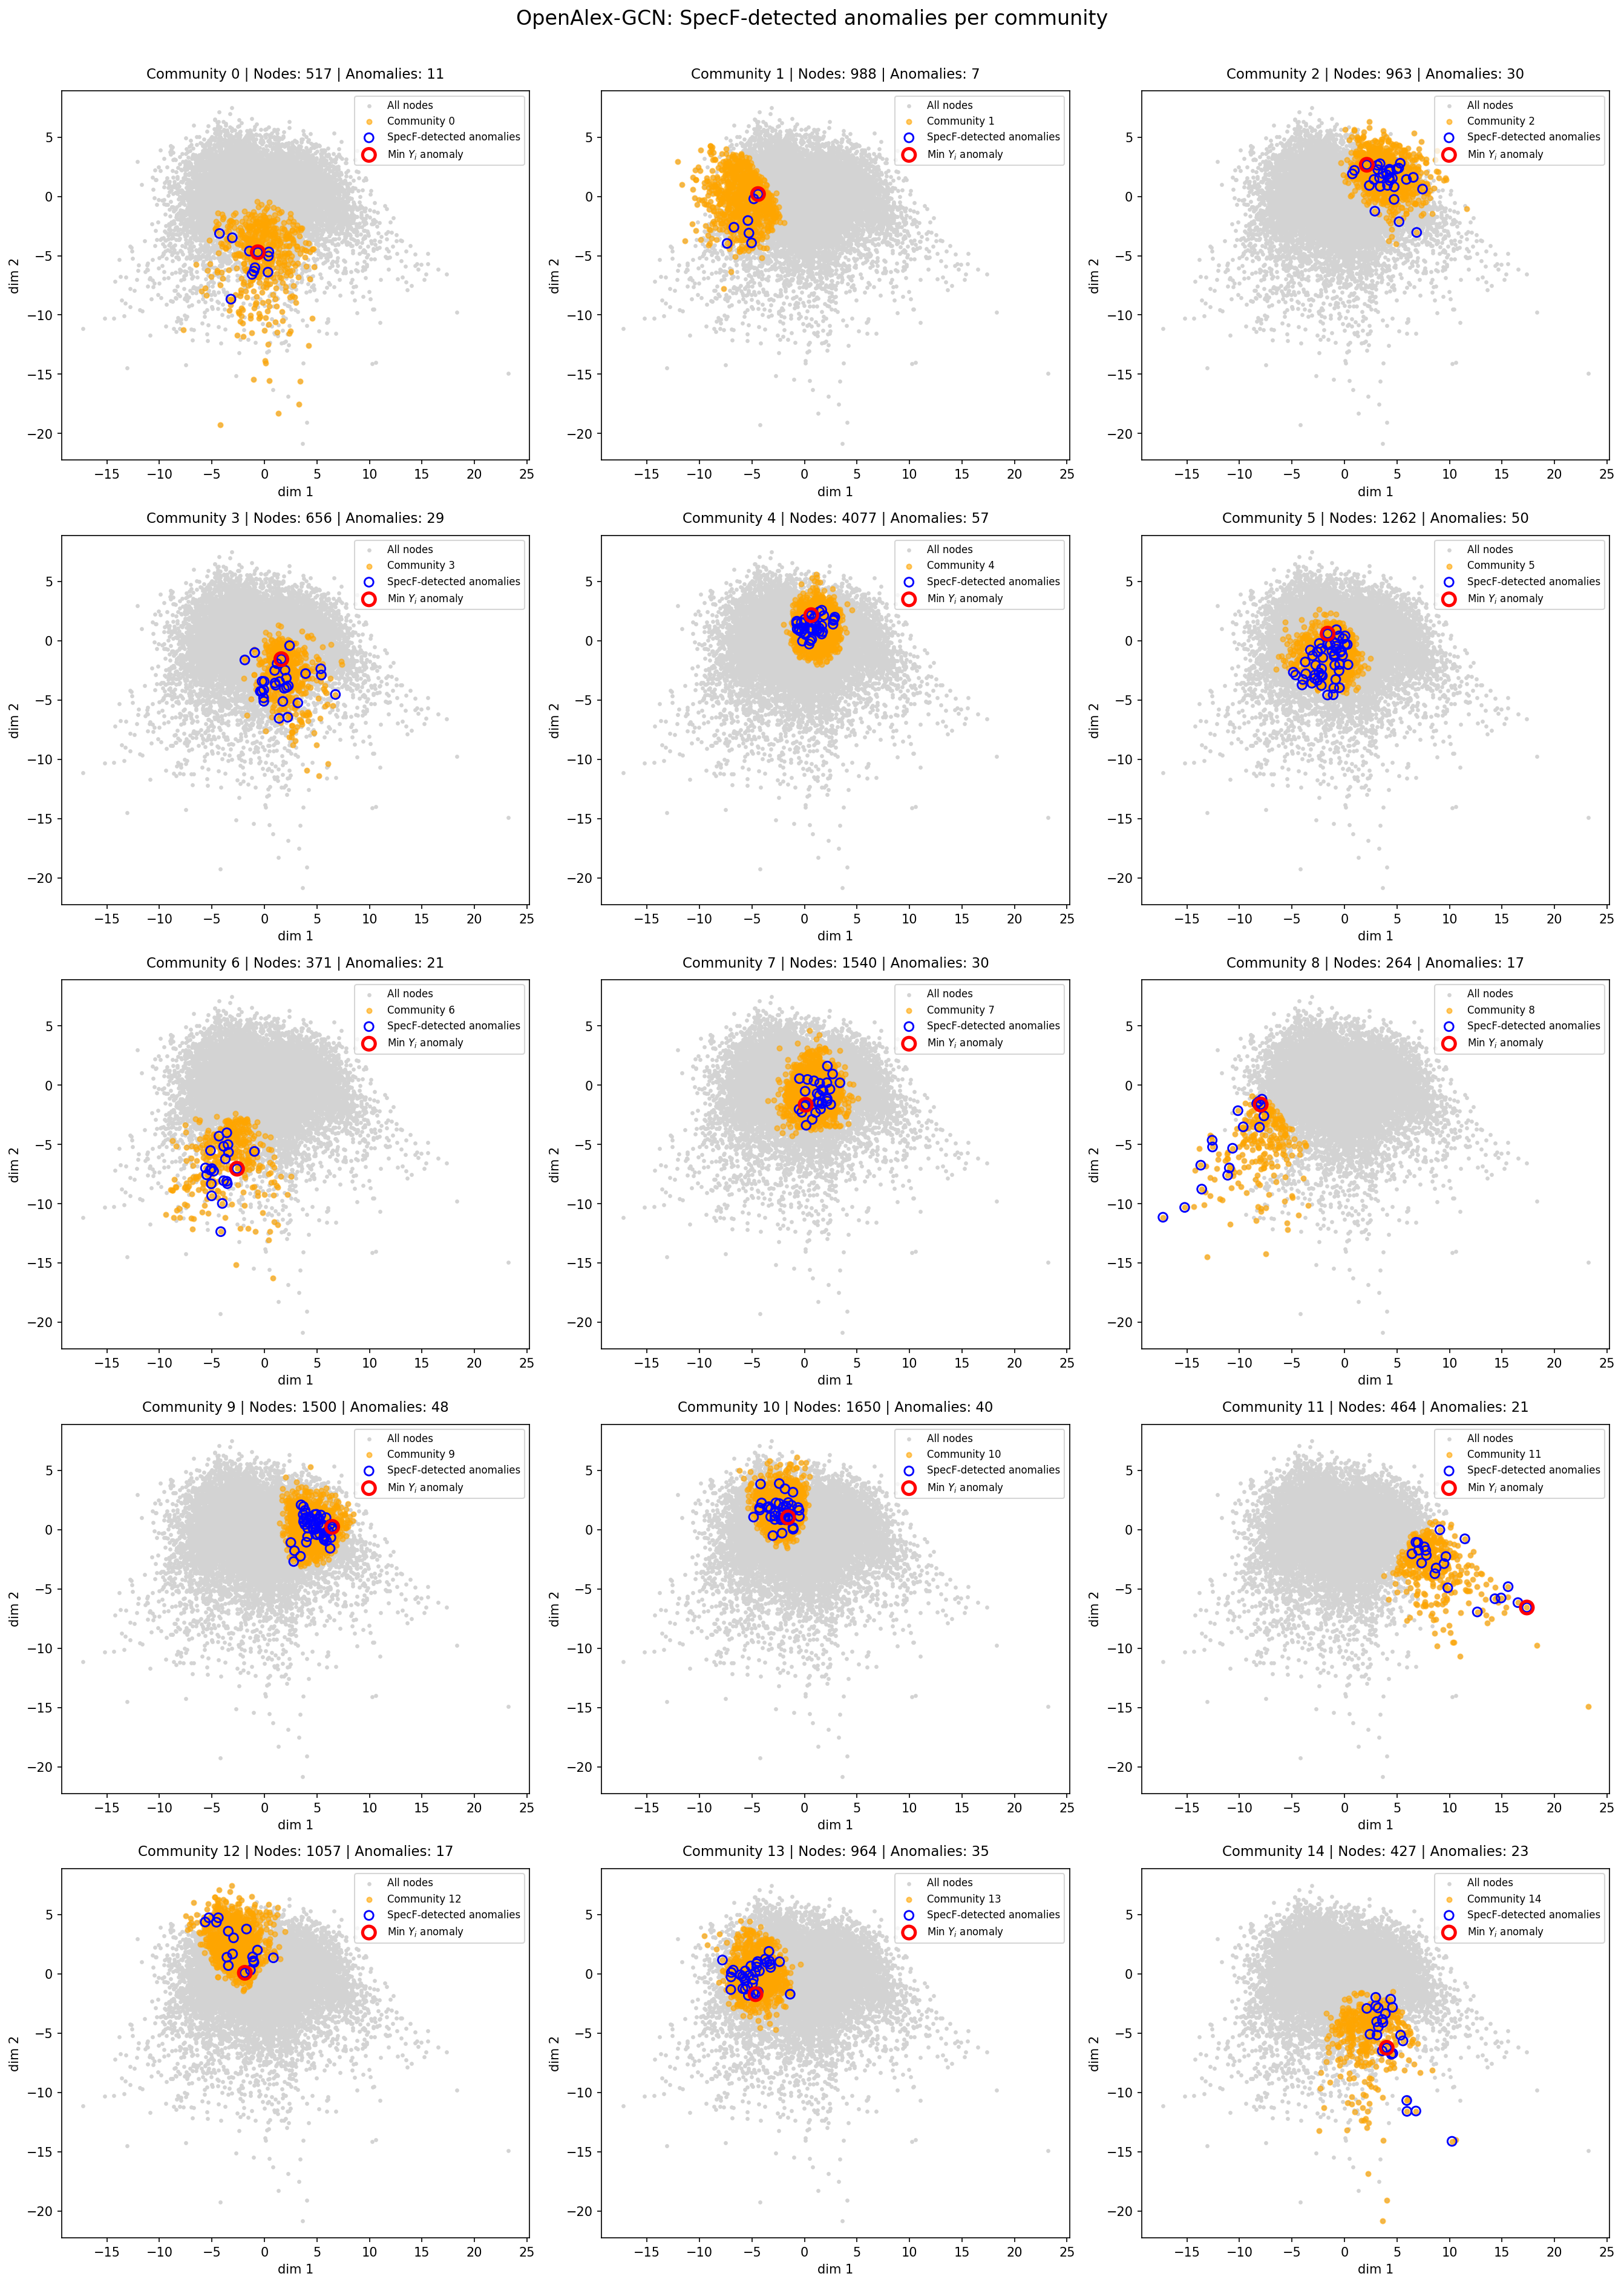

plot saved to: /content/Results/SpecF_detected_anomalies_per_community_minYi_highlighted.png


In [35]:
# --------------------------------------------------
# 1. Prepare Data Alignment
# --------------------------------------------------
# Use the length of your actual OpenAlex data object
N = data.num_nodes
specf_set = set(map(int, specf_anomalies))

# Global anomaly mask
mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True

# Community ID per node (ensure it aligns with PCA matrix X2)
comm_ids = np.array([clusters_dict[i] for i in range(N)], dtype=int)
all_comms = np.sort(np.unique(comm_ids))

# Deviation scores for highlighting edge cases
vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)

# --------------------------------------------------
# 2. Layout & Export Settings
# --------------------------------------------------
cols = 3
rows = math.ceil(len(all_comms) / cols)

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
out_png = RESULTS_DIR / "SpecF_detected_anomalies_per_community_minYi_highlighted.png"

# --------------------------------------------------
# 3. Plotting the Community PCA Grid
# --------------------------------------------------
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), dpi=150)
axes = np.array(axes).reshape(-1)

for ax_i, community_to_show in enumerate(all_comms):
    ax = axes[ax_i]

    # Filters for this specific community
    mask_comm = (comm_ids == community_to_show)
    mask_comm_anom = mask_comm & mask_anom

    # A. Background: All other papers in the graph (Light Grey)
    ax.scatter(X2[:, 0], X2[:, 1], s=5, color="lightgray", label="All nodes")

    # B. Community Nodes: The orange "cluster" of papers
    ax.scatter(
        X2[mask_comm, 0], X2[mask_comm, 1],
        s=15, color="orange", alpha=0.6, label=f"Community {community_to_show}"
    )

    # C. Anomalies: Blue circles for all flagged outliers
    if mask_comm_anom.sum() > 0:
        ax.scatter(
            X2[mask_comm_anom, 0], X2[mask_comm_anom, 1],
            s=50, edgecolors="blue", facecolors="none",
            linewidths=1.4, label="SpecF-detected anomalies"
        )

        # D. Borderline Anomaly: The red highlight (lowest deviation score)
        # This identifies the "subtlest" outlier in the cluster
        anom_idx = np.where(mask_comm_anom)[0]
        min_node = anom_idx[np.argmin(vals_Y[anom_idx])]

        ax.scatter(
            X2[min_node, 0], X2[min_node, 1],
            s=100, edgecolors="red", facecolors="none",
            linewidths=2.5, label="Min $Y_i$ anomaly"
        )

    # Styling the Subplots
    ax.set_title(
        f"Community {community_to_show} | Nodes: {mask_comm.sum()} | Anomalies: {mask_comm_anom.sum()}",
        fontsize=11, pad=10
    )
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")

    # Show legend on the subplots
    ax.legend(loc="upper right", fontsize=8, frameon=True)

# Turn off empty subplots
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

# Global Figure Title
fig.suptitle("OpenAlex-GCN: SpecF-detected anomalies per community",
             fontsize=16, y=1.005)
plt.tight_layout()

# --------------------------------------------------
# 4. Save and Finish
# --------------------------------------------------
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"plot saved to: {out_png.resolve()}")

# Community-specific localization of SpecF-detected anomalies in PCA space

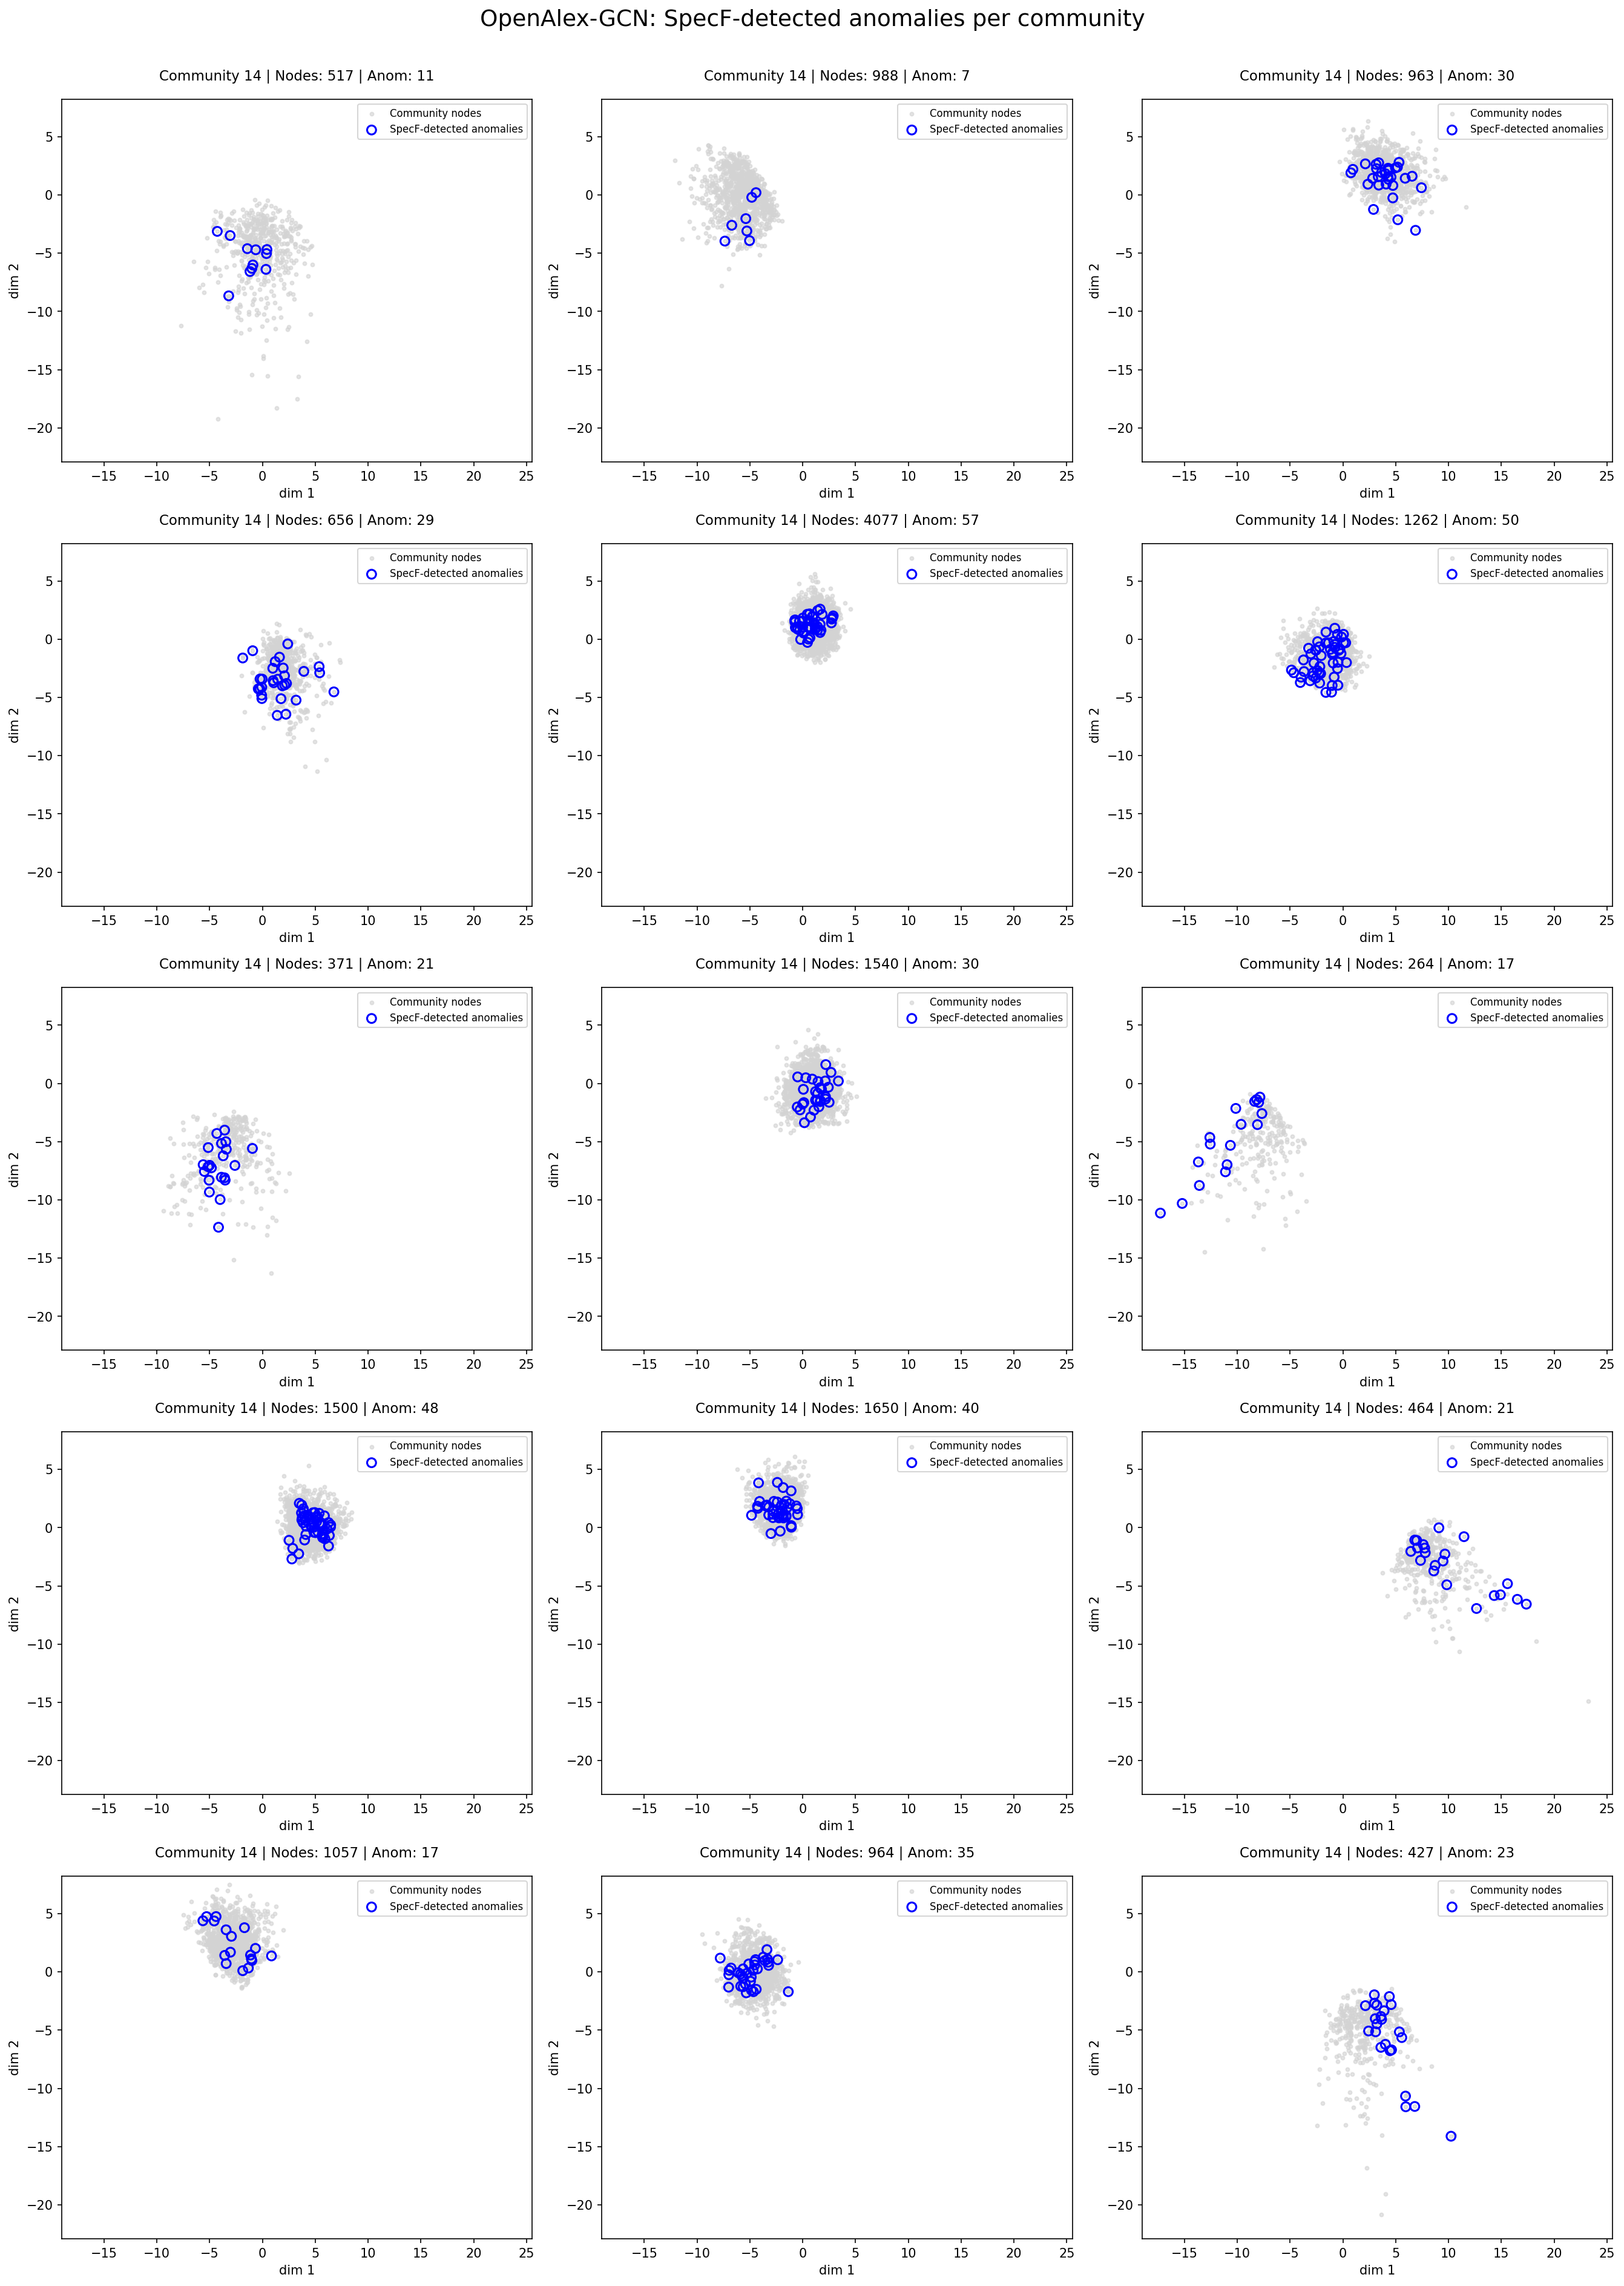

plot saved to: /content/Results/SpecF_anomalies_per_community_onlyCommunityNodes.png


In [36]:
# --------------------------------------------------
# 1. Prepare Masks and Metadata
# --------------------------------------------------
N = data.num_nodes # Standard alignment for your OpenAlex object
specf_set = set(map(int, specf_anomalies))

# SpecF anomaly mask (global)
mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True

# Community mapping (aligned with X2 indexing)
comm_ids = np.array([clusters_dict[i] for i in range(N)], dtype=int)
all_comms = np.sort(np.unique(comm_ids))

# Calculate fixed axes limits based on ALL nodes for a fair comparison
x_min, x_max = np.min(X2[:, 0]), np.max(X2[:, 0])
y_min, y_max = np.min(X2[:, 1]), np.max(X2[:, 1])

# Layout Settings
cols = 3
rows = math.ceil(len(all_comms) / cols)

# --------------------------------------------------
# 2. Results Folder Setup
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Updated filename for OpenAlex
out_png = RESULTS_DIR / "SpecF_anomalies_per_community_onlyCommunityNodes.png"

# --------------------------------------------------
# 3. Plotting the Clean Community Grid
# --------------------------------------------------
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), dpi=150)
axes = np.array(axes).reshape(-1)

for ax_i, c in enumerate(all_comms):
    ax = axes[ax_i]

    # Filter for nodes in THIS community ONLY
    mask_comm = (comm_ids == c)
    mask_comm_anom = mask_comm & mask_anom

    # A. Background: ONLY nodes belonging to this specific community (Grey)
    ax.scatter(
        X2[mask_comm, 0], X2[mask_comm, 1],
        s=8, color="lightgray", alpha=0.6, label="Community nodes"
    )

    # B. Foreground: Anomalies inside this community (Blue Circles)
    if mask_comm_anom.sum() > 0:
        ax.scatter(
            X2[mask_comm_anom, 0], X2[mask_comm_anom, 1],
            s=50, edgecolors="blue", facecolors="none",
            linewidths=1.5, label="SpecF-detected anomalies"
        )

    # C. Formatting
    ax.set_title(
        f"Community {community_to_show} | Nodes: {mask_comm.sum()} | Anom: {mask_comm_anom.sum()}",
        fontsize=11, pad=15
    )
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")

    # Keeping the axes FIXED allows us to see the "spatial shift" between communities
    ax.set_xlim(x_min * 1.1, x_max * 1.1)
    ax.set_ylim(y_min * 1.1, y_max * 1.1)

    # Show legend on the subplots
    ax.legend(loc="upper right", fontsize=8, frameon=True)

# Turn off empty subplots
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

# Global Figure Title
fig.suptitle("OpenAlex-GCN: SpecF-detected anomalies per community",
             fontsize=18, y=1.005)
plt.tight_layout()

# --------------------------------------------------
# 4. Save and Export
# --------------------------------------------------
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"plot saved to: {out_png.resolve()}")

# dominant subject at all nodes VS dominant subject at anomalous nodes

In [37]:
# -------------------------------------------------
# 1. Build Anomaly Flag
# -------------------------------------------------
# Ensure specf_set contains integers for matching with node_id
specf_set = set(map(int, specf_anomalies))
df = df_results.copy()
df["is_anom"] = df["node_id"].astype(int).isin(specf_set)

# -------------------------------------------------
# 2. Analyze Community Composition
# -------------------------------------------------
summary_rows = []

for c, g in df.groupby("community_id"):
    # The most common domain in the whole community
    subj_all = g["subject_name"].value_counts().idxmax()
    total_nodes = len(g)

    # Analyze the anomalies within this community
    g_anom = g[g["is_anom"]]
    if len(g_anom) > 0:
        # What is the dominant domain among the outliers?
        subj_anom = g_anom["subject_name"].value_counts().idxmax()
        anom_count = len(g_anom)
        anom_pct = (anom_count / total_nodes) * 100
    else:
        subj_anom = "N/A"
        anom_count = 0
        anom_pct = 0.0

    summary_rows.append({
        "Community ID": c,
        "Dominant Subject (All)": subj_all,
        "Dominant Subject (Anomalies)": subj_anom,
        "Total Nodes": total_nodes,
        "Anomaly Count": anom_count,
        "Anomaly %": f"{anom_pct:.2f}%"
    })

# -------------------------------------------------
# 3. Display
# -------------------------------------------------
df_comm_summary = pd.DataFrame(summary_rows).sort_values("Community ID")
display(df_comm_summary)

Community ID Dominant Subject (All) Dominant Subject (Anomalies)  \
0              0                Biology                  Mathematics   
1              1      Political Science                    Economics   
2              2                Geology                      Geology   
3              3                Biology                      Biology   
4              4                Geology                     Medicine   
5              5               Medicine                     Medicine   
6              6               Medicine                     Medicine   
7              7            Mathematics             Computer Science   
8              8       Computer Science             Computer Science   
9              9      Materials Science            Materials Science   
10            10               Business                     Business   
11            11              Chemistry            Materials Science   
12            12              Sociology                    Sociology   
13            13               Business                     Business   
14            14       Computer Science                      Physics   

    Total Nodes  Anomaly Count Anomaly %  
0           517             11     2.13%  
1           988              7     0.71%  
2           963             30     3.12%  
3           656             29     4.42%  
4          4077             57     1.40%  
5          1262             50     3.96%  
6           371             21     5.66%  
7          1540             30     1.95%  
8           264             17     6.44%  
9          1500             48     3.20%  
10         1650             40     2.42%  
11          464             21     4.53%  
12         1057             17     1.61%  
13          964             35     3.63%  
14          427             23     5.39%

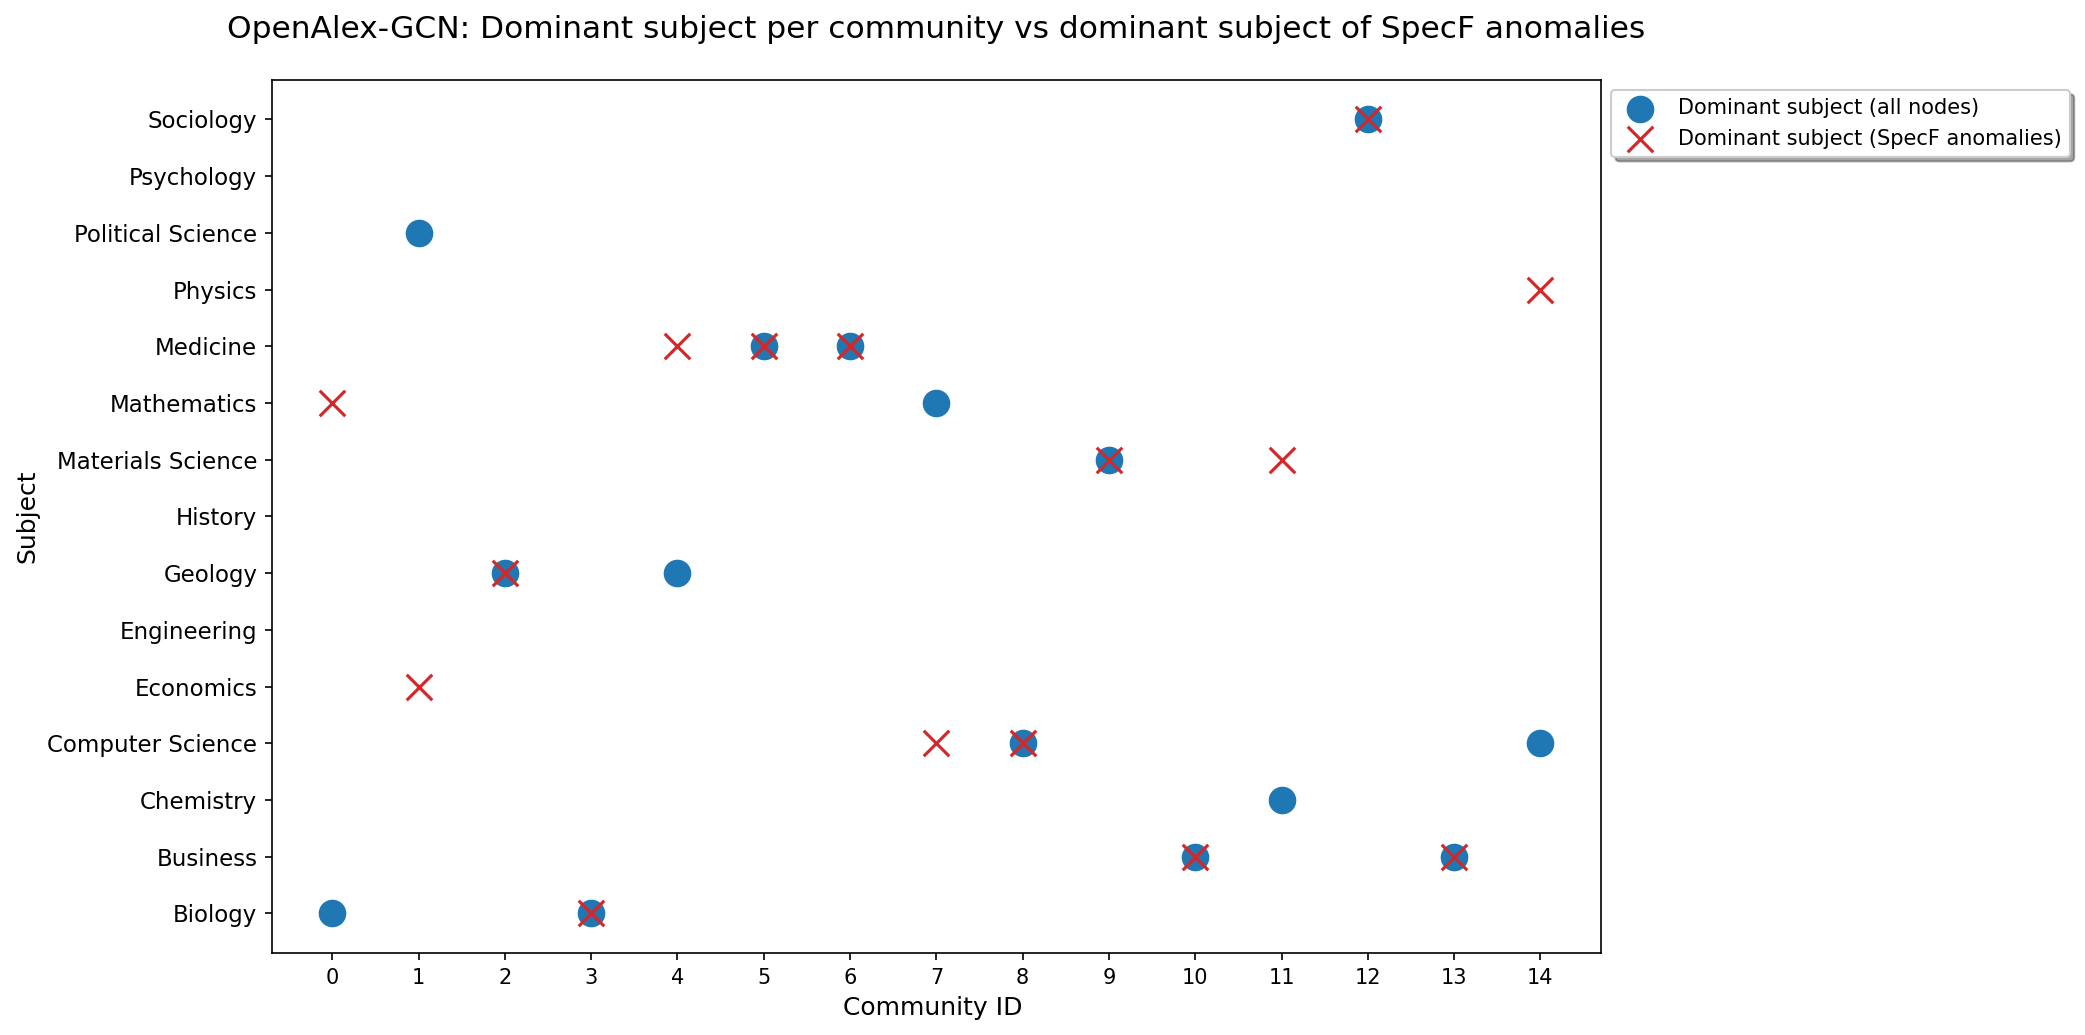

Comparison plot saved to: /content/Results/Dominant_subjects_per_community_vs_anomalies.png


In [39]:
# -------------------------------------------------
# 1. Prepare Subject Mapping
# -------------------------------------------------
# Use the unique subjects from your OpenAlex results
subjects = sorted(df["subject_name"].unique())
subject_to_id = {s: i for i, s in enumerate(subjects)}

# Map names to IDs for plotting on the Y-axis
df_comm_summary["subj_all_id"] = df_comm_summary["Dominant Subject (All)"].map(subject_to_id)
df_comm_summary["subj_anom_id"] = df_comm_summary["Dominant Subject (Anomalies)"].map(
    lambda x: subject_to_id[x] if x in subject_to_id else -1
)

# -------------------------------------------------
# 2. Results Folder & Filename
# -------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
out_png = RESULTS_DIR / "Dominant_subjects_per_community_vs_anomalies.png"

# -------------------------------------------------
# 3. Plotting
# -------------------------------------------------
fig = plt.figure(figsize=(14, 7), dpi=150)
x = np.arange(len(df_comm_summary))

# A. Dominant subject of all nodes (Blue Circles)
plt.scatter(
    x,
    df_comm_summary["subj_all_id"],
    s=150,
    label="Dominant subject (all nodes)",
    color="tab:blue",
)

# B. Dominant subject of anomalies (Red X)
# Nodes where subj_anom_id is -1 (N/A) will be plotted off-graph or can be filtered
plt.scatter(
    x,
    df_comm_summary["subj_anom_id"],
    s=150,
    label="Dominant subject (SpecF anomalies)",
    color="tab:red",
    marker="x",
)

# -------------------------------------------------
# 4. Formatting
# -------------------------------------------------
plt.xticks(x, df_comm_summary["Community ID"], rotation=0, fontsize=10)
plt.yticks(
    np.arange(len(subjects)),
    subjects,
    fontsize=11
)

plt.xlabel("Community ID ", fontsize=12)
plt.ylabel("Subject", fontsize=12)
plt.title("OpenAlex-GCN: Dominant subject per community vs dominant subject of SpecF anomalies", fontsize=15, pad=20)
plt.legend(frameon=True, shadow=True, loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

# Save the plot
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Comparison plot saved to: {out_png.resolve()}")

# min Y value and max Y value per community

In [40]:
# --------------------------------------------------
# Min / Max / Gap of SpecF_score for ALL nodes per community
# --------------------------------------------------
comm_minmax = (
    df.groupby("community_id")["SpecF_score"]
      .agg(
          min_Y="min",
          max_Y="max",
          num_nodes="count"
      )
      .reset_index()
      .sort_values("community_id")
)

# add gap
comm_minmax["Y_gap"] = comm_minmax["max_Y"] - comm_minmax["min_Y"]

display(comm_minmax)



community_id         min_Y         max_Y  num_nodes         Y_gap
0              0  8.729515e+03  1.303407e+08        517  1.303320e+08
1              1  1.134478e+03  2.202915e+08        988  2.202904e+08
2              2  3.568975e+03  2.926127e+07        963  2.925770e+07
3              3  1.309493e+03  6.804935e+07        656  6.804804e+07
4              4  2.653371e+02  7.442012e+07       4077  7.441986e+07
5              5  3.769797e+04  3.259111e+08       1262  3.258734e+08
6              6  6.533554e+05  1.370447e+09        371  1.369793e+09
7              7  7.336604e+03  1.280447e+08       1540  1.280374e+08
8              8  5.665025e+04  2.631397e+08        264  2.630830e+08
9              9  2.101631e+03  1.893523e+08       1500  1.893502e+08
10            10  1.741473e+02  6.279826e+07       1650  6.279808e+07
11            11  1.812544e+04  3.768258e+08        464  3.768076e+08
12            12  2.655050e+03  6.829145e+07       1057  6.828879e+07
13            13  1.101834e+04  1.662781e+08        964  1.662671e+08
14            14  2.182335e+06  7.841482e+08        427  7.819659e+08

**Visualize the gap**

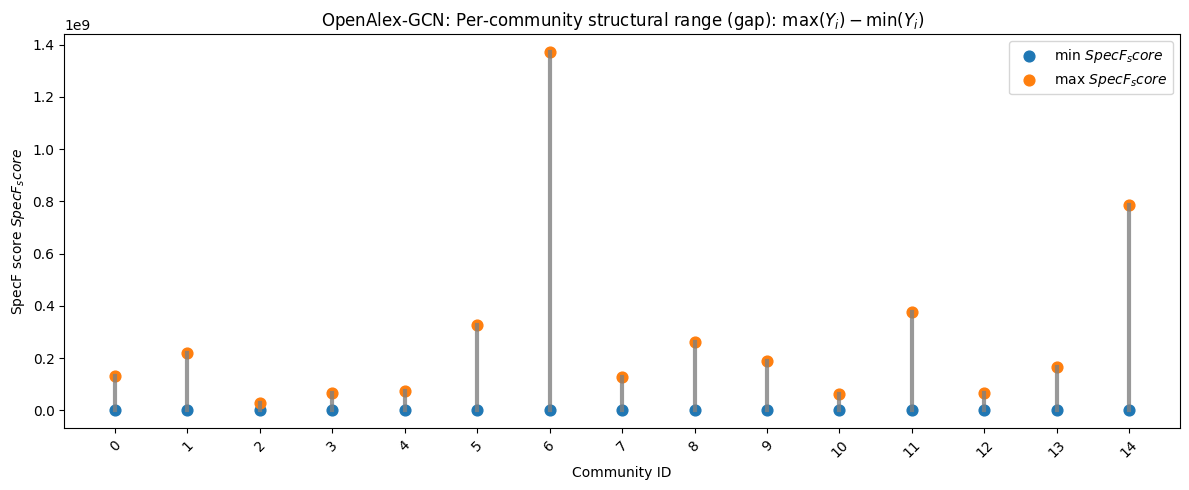

In [41]:
# -----------------------------
# 1) Validate required columns
# -----------------------------
if "community_id" not in df.columns:
    raise ValueError("df must contain a 'community_id' column.")

# allow either Y_i or SpecF_score
score_col = None
for c in ["Y_i", "SpecF_score", "SpecF_score_Y", "Y_score"]:
    if c in df.columns:
        score_col = c
        break

if score_col is None:
    raise ValueError("df must contain a score column like 'Y_i' or 'SpecF_score'.")

# -----------------------------
# 2) Aggregate per community
# -----------------------------
comm_minmax = (
    df.groupby("community_id")[score_col]
      .agg(min_Y="min", max_Y="max")
      .reset_index()
      .sort_values("community_id")
)

x = np.arange(len(comm_minmax))

# -----------------------------
# 3) Plot
# -----------------------------
plt.figure(figsize=(12, 5))

# vertical range line for each community (SAME COLOR)
for i, row in enumerate(comm_minmax.itertuples(index=False)):
    plt.plot(
        [i, i],
        [row.min_Y, row.max_Y],
        linewidth=3,
        color="gray",
        alpha=0.8
    )

# mark min and max points
plt.scatter(x, comm_minmax["min_Y"], s=60, label=rf"min ${score_col}$")
plt.scatter(x, comm_minmax["max_Y"], s=60, label=rf"max ${score_col}$")

plt.xticks(x, comm_minmax["community_id"].astype(int), rotation=45)
plt.xlabel("Community ID")
plt.ylabel(rf"SpecF score ${score_col}$")
plt.title(r"OpenAlex-GCN: Per-community structural range (gap): $\max(Y_i)-\min(Y_i)$")
plt.legend()
plt.tight_layout()
plt.show()


# Top 20 words in normal nodes VS top 20 words in anomalous nodes

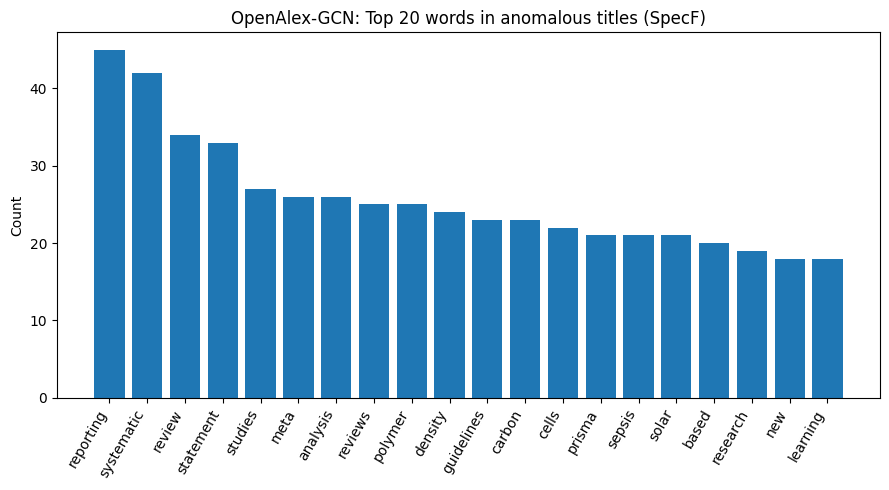

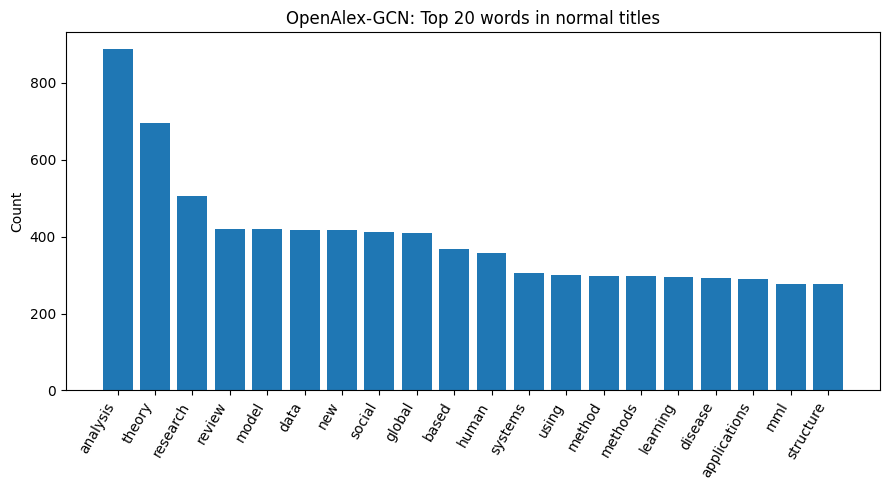

In [42]:
# ------------------------------------------------------------
# 0) Build anomaly mask from specf_anomalies (NO SpecF_anomaly column needed)
# ------------------------------------------------------------
# df_results MUST contain "node_id"
specf_set = set(map(int, specf_anomalies))

anom_mask = df_results["node_id"].astype(int).isin(specf_set).values  # boolean mask aligned to df_results rows


# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def _clean_and_tokenize(t):
    t = str(t).lower()
    toks = re.split(r"[^a-z0-9]+", t)
    toks = [w for w in toks if len(w) >= 3 and w not in ENGLISH_STOP_WORDS]
    return toks

def _top_words(series_titles, topk=20):
    all_tokens = []
    for tt in series_titles.astype(str).values:
        all_tokens.extend(_clean_and_tokenize(tt))
    cnt = Counter(all_tokens)
    return cnt.most_common(topk)


# ============================================================
# Plot 2: Word frequency contrast (top words) anomalies vs normal
# ============================================================
topk = 20
top_anom = _top_words(df_results.loc[anom_mask, "title"], topk=topk)
top_norm = _top_words(df_results.loc[~anom_mask, "title"], topk=topk)

# anomalies bar chart
if len(top_anom) > 0:
    words_a, vals_a = zip(*top_anom)
    x = np.arange(len(words_a))
    plt.figure(figsize=(9, 5))
    plt.bar(x, vals_a)
    plt.xticks(x, words_a, rotation=60, ha="right")
    plt.ylabel("Count")
    plt.title(f"OpenAlex-GCN: Top {topk} words in anomalous titles (SpecF)")
    plt.tight_layout()
    plt.show()

# normal bar chart
if len(top_norm) > 0:
    words_n, vals_n = zip(*top_norm)
    x = np.arange(len(words_n))
    plt.figure(figsize=(9, 5))
    plt.bar(x, vals_n)
    plt.xticks(x, words_n, rotation=60, ha="right")
    plt.ylabel("Count")
    plt.title(f"OpenAlex-GCN: Top {topk} words in normal titles")
    plt.tight_layout()
    plt.show()






# min Y value of an anomalous node and max Y value of a normal node per community

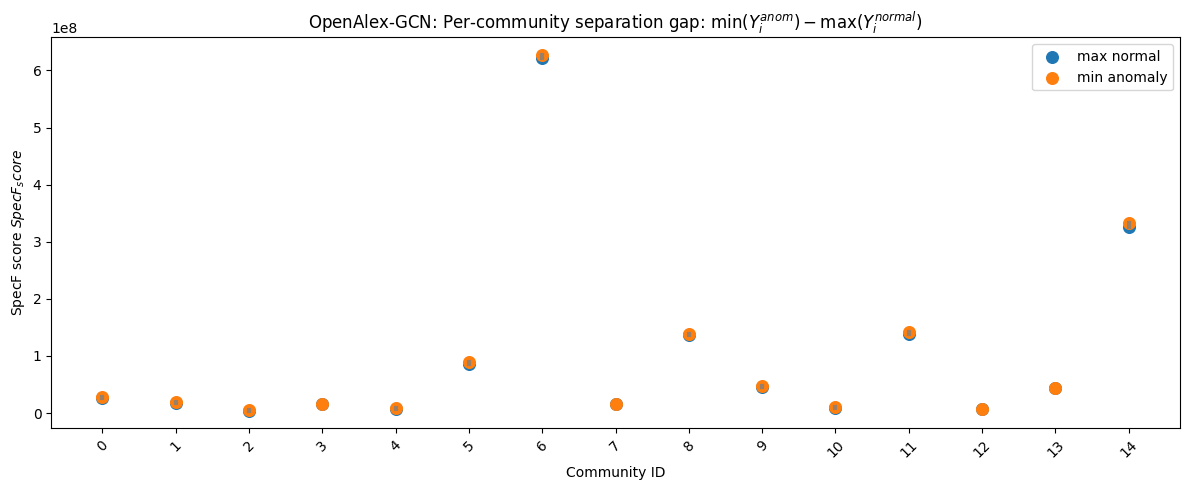

In [43]:
# -----------------------------
# 1) Validate required columns
# -----------------------------
required_cols = {"community_id", "is_anom"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"df is missing required columns: {missing}")

# allow either Y_i or SpecF_score
score_col = None
for c in ["Y_i", "SpecF_score", "SpecF_score_Y", "Y_score"]:
    if c in df.columns:
        score_col = c
        break

if score_col is None:
    raise ValueError("df must contain a score column like 'Y_i' or 'SpecF_score'.")

# -----------------------------
# 2) Aggregate per community
# -----------------------------
rows = []

for c, g in df.groupby("community_id"):
    g_norm = g[~g["is_anom"]]
    g_anom = g[g["is_anom"]]

    # skip communities without both types
    if len(g_norm) == 0 or len(g_anom) == 0:
        continue

    max_normal = g_norm[score_col].max()
    min_anom   = g_anom[score_col].min()

    rows.append({
        "community_id": int(c),
        "max_normal": max_normal,
        "min_anom": min_anom,
        "gap": min_anom - max_normal
    })

comm_gap = (
    pd.DataFrame(rows)
    .sort_values("community_id")
    .reset_index(drop=True)
)

x = np.arange(len(comm_gap))

# -----------------------------
# 3) Plot
# -----------------------------
plt.figure(figsize=(12, 5))

# vertical gap line (same color)
for i, row in comm_gap.iterrows():
    plt.plot(
        [i, i],
        [row.max_normal, row.min_anom],
        color="gray",
        linewidth=3,
        alpha=0.8
    )

# mark max normal & min anomaly
plt.scatter(x, comm_gap["max_normal"], s=70, label="max normal")
plt.scatter(x, comm_gap["min_anom"], s=70, label="min anomaly")

plt.xticks(x, comm_gap["community_id"], rotation=45)
plt.xlabel("Community ID")
plt.ylabel(rf"SpecF score ${score_col}$")
plt.title(r"OpenAlex-GCN: Per-community separation gap: $\min(Y_i^{anom}) - \max(Y_i^{normal})$")
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
# --------------------------------------------------
# Build base dataframe
# --------------------------------------------------
df = df_results.copy()

# anomaly mask
specf_set = set(map(int, specf_anomalies))
df["is_anom"] = df["node_id"].astype(int).isin(specf_set)

# attach Y_i score
if isinstance(Y_scores, dict):
    df["Y_i"] = df["node_id"].astype(int).map(lambda i: float(Y_scores[int(i)]))
else:
    df["Y_i"] = df["node_id"].astype(int).map(lambda i: float(Y_scores[int(i)]))

# --------------------------------------------------
# Compute per-community stats
# --------------------------------------------------
rows = []

for c, g in df.groupby("community_id"):
    # normal nodes
    g_norm = g[~g["is_anom"]]
    # anomalous nodes
    g_anom = g[g["is_anom"]]

    max_normal = g_norm["Y_i"].max() if len(g_norm) > 0 else np.nan
    min_anom   = g_anom["Y_i"].min() if len(g_anom) > 0 else np.nan

    rows.append({
        "community_id": c,
        "num_nodes": len(g),
        "num_normals": len(g_norm),
        "num_anomalies": len(g_anom),
        "max_Y_normal": max_normal,
        "min_Y_anomaly": min_anom,
        "gap(min_anom - max_normal)": (
            min_anom - max_normal
            if not np.isnan(max_normal) and not np.isnan(min_anom)
            else np.nan
        )
    })

df_gap = pd.DataFrame(rows).sort_values("community_id")
display(df_gap)


community_id  num_nodes  num_normals  num_anomalies  max_Y_normal  \
0              0        517          506             11  2.604411e+07   
1              1        988          981              7  1.808876e+07   
2              2        963          933             30  4.440894e+06   
3              3        656          627             29  1.495415e+07   
4              4       4077         4020             57  7.753761e+06   
5              5       1262         1212             50  8.663756e+07   
6              6        371          350             21  6.219085e+08   
7              7       1540         1510             30  1.508722e+07   
8              8        264          247             17  1.361720e+08   
9              9       1500         1452             48  4.630518e+07   
10            10       1650         1610             40  9.644820e+06   
11            11        464          443             21  1.379858e+08   
12            12       1057         1040             17  6.292384e+06   
13            13        964          929             35  4.428325e+07   
14            14        427          404             23  3.250002e+08   

    min_Y_anomaly  gap(min_anom - max_normal)  
0    2.783274e+07                1.788628e+06  
1    1.992686e+07                1.838098e+06  
2    4.763045e+06                3.221510e+05  
3    1.508184e+07                1.276954e+05  
4    7.950783e+06                1.970225e+05  
5    8.906035e+07                2.422793e+06  
6    6.268283e+08                4.919791e+06  
7    1.576160e+07                6.743832e+05  
8    1.380747e+08                1.902735e+06  
9    4.805312e+07                1.747942e+06  
10   9.993720e+06                3.489000e+05  
11   1.426099e+08                4.624128e+06  
12   7.444687e+06                1.152303e+06  
13   4.456912e+07                2.858671e+05  
14   3.327275e+08                7.727319e+06

# Top 5 titles in normal nodes VS top 5 titles in anomalous node

In [45]:
# --------------------------------------------------
# 1. Prepare Dataframe with OpenAlex Metadata
# --------------------------------------------------
df = df_results.copy()

# Ensure types match for mapping
specf_set = set(map(int, specf_anomalies))
df["is_anom"] = df["node_id"].astype(int).isin(specf_set)

# Attach the Deviation Score (Y_i)
df["Y_i"] = df["node_id"].astype(int).map(lambda i: float(Y_scores[int(i)]))

# --------------------------------------------------
# 2. Helper: Numbered Titles for HTML/Excel
# --------------------------------------------------
def numbered_multiline(titles):
    return "\n".join(f"{i+1}. {t}" for i, t in enumerate(titles))

# --------------------------------------------------
# 3. Collect Top-5 Titles per Research Community
# --------------------------------------------------
rows = []

for c, g in df.groupby("community_id"):
    # Normal nodes with highest deviation (the most "interesting" normal papers)
    top_norm = (
        g[~g["is_anom"]]
        .sort_values("Y_i", ascending=False)
        .head(5)
    )

    # Anomalous nodes with highest deviation (the most "extreme" outliers)
    top_anom = (
        g[g["is_anom"]]
        .sort_values("Y_i", ascending=False)
        .head(5)
    )

    rows.append({
        "Community ID": c,
        "Top 5 Normal Titles (High Y_i)": numbered_multiline(top_norm["title"].tolist()),
        "Top 5 Anomalous Titles": numbered_multiline(top_anom["title"].tolist())
    })

df_top_titles = (
    pd.DataFrame(rows)
    .sort_values("Community ID")
    .reset_index(drop=True)
)

# --------------------------------------------------
# 4. Display HTML Table in Notebook
# --------------------------------------------------
def newline_to_br(text):
    if not isinstance(text, str):
        return text
    return text.replace("\n", "<br>")

df_display = df_top_titles.copy()
df_display["Top 5 Normal Titles (High Y_i)"] = df_display["Top 5 Normal Titles (High Y_i)"].apply(newline_to_br)
df_display["Top 5 Anomalous Titles"] = df_display["Top 5 Anomalous Titles"].apply(newline_to_br)

print("### Top Titles per Community Analysis (OpenAlex Subset)")
display(HTML(df_display.to_html(escape=False, index=False)))

# --------------------------------------------------
# 5. Export to Excel (Results folder)
# --------------------------------------------------

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Updated filename for OpenAlex
output_file = RESULTS_DIR / "OpenAlex_top5_titles_per_community_GCN.xlsx"
df_top_titles.to_excel(output_file, index=False)

# Enable wrap-text formatting for readability in Excel
wb = load_workbook(output_file)
ws = wb.active
wrap = Alignment(wrap_text=True, vertical="top")

headers = [cell.value for cell in ws[1]]
col_norm = headers.index("Top 5 Normal Titles (High Y_i)") + 1
col_anom = headers.index("Top 5 Anomalous Titles") + 1

for row in range(2, ws.max_row + 1):
    ws.cell(row=row, column=col_norm).alignment = wrap
    ws.cell(row=row, column=col_anom).alignment = wrap

# Auto-adjust column width for titles
ws.column_dimensions[ws.cell(row=1, column=col_norm).column_letter].width = 60
ws.column_dimensions[ws.cell(row=1, column=col_anom).column_letter].width = 60

wb.save(output_file)

print(f"\n✅ OpenAlex qualitative results saved to: {output_file.resolve()}")

### Top Titles per Community Analysis (OpenAlex Subset)



✅ OpenAlex qualitative results saved to: /content/Results/OpenAlex_top5_titles_per_community_GCN.xlsx
